In [21]:
##########################################################################
#
# Author: Vlad Mattiussi - University of Bologna
# Email: vlad.mattiussi@studio.unibo.it
# Release: January, 2022
# 
# This R script performs a sentiment & opinion mining classification using 
# keras neural networks, firstly generating word embeddings on movie reviews and then performs
# some texts with LSA method to find similarity between words and queries
# 
# Dataset link: https://www.kaggle.com/bittlingmayer/amazonreviews?select=test.ft.txt.bz2
##########################################################################

In [22]:
#PREPARATION PHASE

In [23]:
#Installing and loading libraries
#install.packages("lsa")
#install.packages("tm")
library("keras")
keras::is_keras_available()
library(text2vec)
library(data.table)

library(tm)
library(lsa)

if(!require("iterators"))
  install.packages("iterators")#, dependencies=TRUE)
library(iterators)

if(!require("yaml"))
  install.packages("yaml")#, dependencies=TRUE)
library(yaml)

if(!require("foreach"))
  install.packages("foreach")#, dependencies=TRUE)
library(foreach)

if(!require("R.utils"))
  install.packages("R.utils")
library("R.utils")

Sys.setenv(KERAS_BACKEND = "GPU")

[1] TRUE

In [24]:
#Loading dataset
data <- read.delim('NewNewTrain.ft.txt')
length(data[,1])

[1] 34896

In [25]:
#Dispaly first 10 rows: the first 10 characters of each row is the correspondig label.
head(data, 10)

X__label__2.Stuning.even.for.the.non.gamer..This.sound.track.was.beautiful..It.paints.the.senery.in.your.mind.so.well.I.would.recomend.it.even.to.people.who.hate.vid..game.music..I.have.played.the.game.Chrono.Cross.but.out.of.all.of.the.games.I.have.ever.played.it.has.the.best.music..It.backs.away.from.crude.keyboarding.and.takes.a.fresher.step.with.grate.guitars.and.soulful.orchestras..It.would.impress.anyone.who.cares.to.listen..._.                                                                                                                                                                                                                                                                                                                                                                                                              
1  __label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.                                                                                                                                                                                                                                                                                                                            
2  __label__2 Amazing!: This soundtrack is my favorite music of all time, hands down. The intense sadness of Prisoners of Fate (which means all the more if you've played the game) and the hope in A Distant Promise and Girl who Stole the Star have been an important inspiration to me personally throughout my teen years. The higher energy tracks like Chrono Cross ~ Time's Scar~, Time of the Dreamwatch, and Chronomantique (indefinably remeniscent of Chrono Trigger) are all absolutely superb as well.This soundtrack is amazing music, probably the best of this composer's work (I haven't heard the Xenogears soundtrack, so I can't say for sure), and even if you've never played the game, it would be worth twice the price to buy it.I wish I could give it 6 stars.                                                                             
3  __label__2 Excellent Soundtrack: I truly like this soundtrack and I enjoy video game music. I have played this game and most of the music on here I enjoy and it's truly relaxing and peaceful.On disk one. my favorites are Scars Of Time, Between Life and Death, Forest Of Illusion, Fortress of Ancient Dragons, Lost Fragment, and Drowned Valley.Disk Two: The Draggons, Galdorb - Home, Chronomantique, Prisoners of Fate, Gale, and my girlfriend likes ZelbessDisk Three: The best of the three. Garden Of God, Chronopolis, Fates, Jellyfish sea, Burning Orphange, Dragon's Prayer, Tower Of Stars, Dragon God, and Radical Dreamers - Unstealable Jewel.Overall, this is a excellent soundtrack and should be brought by those that like video game music.Xander Cross                                                                                  
4  __label__2 Remember, Pull Your Jaw Off The Floor After Hearing it: If you've played the game, you know how divine the music is! Every single song tells a story of the game, it's that good! The greatest songs are without a doubt, Chrono Cross: Time's Scar, Magical Dreamers: The Wind, The Stars, and the Sea and Radical Dreamers: Unstolen Jewel. (Translation varies) This music is perfect if you ask me, the best it can be. Yasunori Mitsuda just poured his heart on and wrote it down on paper.                                                                                                                                                    

In [26]:
#Dividing into labels and texts and inserting them in two separate vectors.
a <- rep(NA, 10)
labels<- vector()
 texts <- vector()
 n = 1
    for(i in data[,1]){
      m = substr(i,1,10)
      o = substr(i,12,nchar(i))
      labels[n] <- m
      texts[n] <- o
      n = n + 1
    }
head(labels,2)
head(texts,2)

[1] "__label__2" "__label__2"

[1] "The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny."                                                                                                                                                                                                                                               
[2] "Amazing!: This soundtrack is my favorite music of all time, hands down. The intense sadness of Prisoners of Fate (which means all the more if you've played the game) and the hope in A Distant Promise and Girl who Stole the Star have been an important inspiration to me personally throughout my teen years. The higher energy tracks like Chrono Cross ~ Time's Scar~, Time of the Dreamwatch, and Chronomantique (indefinably remeniscent of Chrono Trigger) are all absolutely superb as well.This soundtrack is amazing music, probably the best of this composer's work (I haven't heard the Xenogears soundtrack, so I can't say for sure), and even if you've never played the game, it would be worth twice the price to buy it.I wish I could give it 6 stars."

In [27]:
#PREPROCESSING PHASE

In [28]:
#Removing punctuation and stopwords and tokenization of the reviews
tokenize <- function(fulltext) text2vec::word_tokenizer(tolower(fulltext))
text <- removePunctuation(texts)
text = removeWords(text, stopwords('english'))
train_text <- tokenize(text)
head(train_text,2)

#Iterator over tokens
we.train.itoken <- itoken(train_text)

#Creating vocabulary
vocab <- create_vocabulary(we.train.itoken)

#Deletetion of rare terms occuring less than 5 times
vocab <- prune_vocabulary(vocab, term_count_min=5)

vocab.size <- length(vocab$term) # = vocab[,1]
vocab.size
print(vocab)

[[1]]
 [1] "the"         "best"        "soundtrack"  "ever"        "anything"   
 [6] "im"          "reading"     "lot"         "reviews"     "saying"     
[11] "best"        "game"        "soundtrack"  "i"           "figured"    
[16] "id"          "write"       "review"      "disagree"    "bit"        
[21] "this"        "opinino"     "yasunori"    "mitsudas"    "ultimate"   
[26] "masterpiece" "the"         "music"       "timeless"    "im"         
[31] "listening"   "years"       "now"         "beauty"      "simply"     
[36] "refuses"     "fadethe"     "price"       "tag"         "pretty"     
[41] "staggering"  "i"           "must"        "say"         "going"      
[46] "buy"         "cd"          "much"        "money"       "one"        
[51] "i"           "feel"        "worth"       "every"       "penny"      

[[2]]
 [1] "amazing"        "this"           "soundtrack"     "favorite"      
 [5] "music"          "time"           "hands"          "the"           
 [9] "intense"        "sadness"        "prisoners"      "fate"          
[13] "means"          "youve"          "played"         "game"          
[17] "hope"           "a"              "distant"        "promise"       
[21] "girl"           "stole"          "star"           "important"     
[25] "inspiration"    "personally"     "throughout"     "teen"          
[29] "years"          "the"            "higher"         "energy"        
[33] "tracks"         "like"           "chrono"         "cross"         
[37] "times"          "scar"           "time"           "dreamwatch"    
[41] "chronomantique" "indefinably"    "remeniscent"    "chrono"        
[45] "trigger"        "absolutely"     "superb"         "wellthis"      
[49] "soundtrack"     "amazing"        "music"          "probably"      
[53] "best"           "composers"      "work"           "i"             
[57] "havent"         "heard"          "xenogears"      "soundtrack"    
[61] "i"              "cant"           "say"            "sure"          
[65] "even"           "youve"          "never"          "played"        
[69] "game"           "worth"          "twice"          "price"         
[73] "buy"            "iti"            "wish"           "i"             
[77] "give"           "6"              "stars"

[1] 26023

Number of docs: 34896 
0 stopwords:  ... 
ngram_min = 1; ngram_max = 1 
Vocabulary: 
             term term_count doc_count
    1:     atwood          5         5
    2:       loon          5         3
    3: healthcare          5         3
    4:   touchpad          5         1
    5:      harms          5         5
   ---                                
26019:       this      24983     11036
26020:        one      25712     10299
26021:        the      39324     13719
26022:       book      42742     10696
26023:          i     126861     23743


In [29]:
# one-hot encoding of vocabulary: transformation of each word in a 1-0 vector
#  a.k.a. binarization, e.g. for each term t it generates a vector (row) 
#  with zeros everywhere, except the value 1 in the component corresponding to t  
we.vect <- vocab_vectorizer(vocab)
print(we.vect)

function (iterator, grow_dtm, skip_grams_window_context, window_size, 
    weights) 
{
    vocab_corpus_ptr = cpp_vocabulary_corpus_create(vocabulary$term, 
        attr(vocabulary, "ngram")[[1]], attr(vocabulary, "ngram")[[2]], 
        attr(vocabulary, "stopwords"), attr(vocabulary, "sep_ngram"))
    setattr(vocab_corpus_ptr, "ids", character(0))
    setattr(vocab_corpus_ptr, "class", "VocabCorpus")
    corpus_insert(vocab_corpus_ptr, iterator, grow_dtm, skip_grams_window_context, 
        window_size, weights)
}
<bytecode: 0x000000000d9c73a0>
<environment: 0x000000000d9c87f8>


In [30]:
#WORD EMBEDDING

In [31]:
# creation of the term-term co-occurency matrix
we.train.tcm <- create_tcm(we.train.itoken, we.vect, skip_grams_window=5)

# create word embeddings, each with 50 dimensions, considering at most 10 occurences for word couples
#   and 10 training iterations
wordvecs.size <- 50
#glove.model <- GloVe$new(word_vectors_size=wordvecs.size, vocabulary=vocab, x_max=10)
#glove.model <- GlobalVectors$new(rank = 50, x_max = 10)#, vocabulary = vocab) vocabulary is taken from term-ter co-occurency matrix
glove.model <- GlobalVectors$new(word_vectors_size = wordvecs.size, x_max = 10, vocabulary = vocab)

print(glove.model)

wordvecs <- glove.model$fit_transform(we.train.tcm, n_iter=10, convergence_tol = -1, n_check_convergence = 1L, n_threads = 8)

<GloVe>
  Inherits from: <mlapiDecomposition>
  Public:
    clone: function (deep = FALSE) 
    components: active binding
    dump: function () 
    fit_transform: function (x, n_iter = 10L, convergence_tol = -1, n_check_convergence = 1L, 
    get_history: function () 
    get_word_vectors: function () 
    initialize: function (word_vectors_size, vocabulary, x_max, learning_rate = 0.15, 
    n_dump_every: 0
    shuffle: FALSE
    transform: function (x, y = NULL, ...) 
  Private:
    alpha: 0.75
    b_i: -0.351672035176307 -0.351922932080925 -0.120195444207639 ...
    b_j: -0.357381635345519 0.10493774828501 0.0828841936308891 0 ...
    check_convert_input: function (x) 
    components_: NULL
    cost_history: 
    fitted: FALSE
    glove_fitter: NULL
    grain_size: 100000
    initial: NULL
    internal_matrix_formats: list
    lambda: 0
    learning_rate: 0.15
    set_internal_matrix_formats: function (sparse = NULL, dense = NULL) 
    vocab_terms: atwood loon healthcare touchpad h

In [32]:
# save the word embeddings as an R data file
save(wordvecs, file="embedding.RData")

In [34]:
# embedding of the word "excellent" 
wordvecs["excellent",]

[1] -0.282871425 -0.226601884 -0.136666730 -0.226441935 -0.640884578
 [6]  0.495357662  0.229567781 -0.439132601  0.372662365  0.246376306
[11] -0.077747419  0.998774648 -0.106917724 -0.053956229 -0.381110638
[16] -0.317956865 -0.646845579  0.008820367 -0.330743402  0.408387423
[21]  0.185978085 -0.669458449 -0.175961509  0.206594408  0.106213666
[26] -0.358162761  0.251080871  0.076719567  0.052797675 -0.383593589
[31] -0.206538633 -0.050321169  0.343023300 -0.232009932 -0.345499158
[36] -0.065965340 -0.248461068 -0.031662367  0.120414361 -0.090028726
[41] -0.407178313  0.273807406 -0.503489852  0.260989726  0.092924759
[46] -0.270707756 -0.739982426  0.155433670  0.201182365  0.164337158

In [35]:
# which are the words related to "excellent" ?
# return the similarity matrix of each couple of rows of the two input matrix
#  in this case returns the similarities between the word excellent and all the other words
sim.excellent <- sim2(wordvecs, wordvecs["excellent",,drop=FALSE], method="cosine", norm="l2")

In [36]:
# shows the first top similar words to excellent
head(sort(sim.excellent[,1], decreasing=TRUE))

excellent     great wonderful fantastic   perfect      good 
1.0000000 0.8372693 0.8343521 0.8103603 0.7844544 0.7759295

In [37]:
# shows the first top similar words to excellent wihout excellent itself
head(sort(sim.excellent[sim.excellent[,1]<0.999,1], decreasing=TRUE))

great   wonderful   fantastic     perfect        good outstanding 
  0.8372693   0.8343521   0.8103603   0.7844544   0.7759295   0.7643292

In [38]:
# definition of a function that returns the firts top similar words of an input vector word v
#  ecluding v from the result
similar.words <- function(v, n=15) {
  result = head(sort(sim2(wordvecs, matrix(v, 1, ncol(wordvecs)), method="cosine", norm="l2")[,1], 
                     decreasing=T), n)
  return(result[result<0.9999])
}

In [39]:
# test of the function with...
similar.words(wordvecs["book",])

read   reading     books        it         i    author      this       one 
0.8946653 0.8163581 0.8129499 0.7884584 0.7782386 0.7651200 0.7593826 0.7438849 
    found     story      also       way     novel   however 
0.7395363 0.7326620 0.7308494 0.7244121 0.7242054 0.7225942

In [40]:
str(train_text, list.len=5, vec.len = 7)

List of 34896
 $ : chr [1:55] "the" "best" "soundtrack" "ever" "anything" "im" "reading" ...
 $ : chr [1:79] "amazing" "this" "soundtrack" "favorite" "music" "time" "hands" ...
 $ : chr [1:83] "excellent" "soundtrack" "i" "truly" "like" "soundtrack" "i" ...
 $ : chr [1:58] "remember" "pull" "your" "jaw" "off" "the" "floor" ...
 $ : chr [1:77] "absolute" "masterpiece" "i" "quite" "sure" "actually" "taking" ...
  [list output truncated]


In [41]:
#SENTIMENT ANALYSIS WITH KERAS NEURAL NETWORK

In [42]:
# the keras neural network expects sequences of integer indexes rather than tokens: 
#  we use the vocabulary for mapping tokens to unique indexes
#   it may take a couple of minutes for 10000 reviews
train.indexes <- lapply(train_text, match, vocab$term)

In [43]:
# show first indexed 5 reviews where each word is replaced by the position 
#  of the word in the vocabulary
str(train.indexes, list.len = 5)

List of 34896
 $ : int [1:55] 26021 25996 25028 25983 25832 25979 25965 25922 25844 25329 ...
 $ : int [1:79] 25789 26019 25028 25843 25969 26008 25112 26021 23863 20179 ...
 $ : int [1:83] 25914 25028 26023 25691 26016 25028 26023 25851 25815 25908 ...
 $ : int [1:58] 25545 24684 25368 19099 23484 26021 24365 25793 24844 25994 ...
 $ : int [1:77] 24726 25216 26023 25833 25853 25865 25383 26008 26012 25578 ...
  [list output truncated]


In [44]:
# remove the null values generated by words missing in the vocabulary
train.indices <- lapply(train.indexes, function(s) array(s[!is.na(s),drop=F]-1))
str(train.indices, list.len = 5)

List of 34896
 $ : num [1:51(1d)] 26020 25995 25027 25982 25831 ...
 $ : num [1:74(1d)] 25788 26018 25027 25842 25968 ...
 $ : num [1:71(1d)] 25913 25027 26022 25690 26015 ...
 $ : num [1:55(1d)] 25544 24683 25367 19098 23483 ...
 $ : num [1:69(1d)] 24725 25215 26022 25832 25852 ...
  [list output truncated]


In [45]:
# Finally, we pad the sequences to make them of a fixed length of 200 words to obtain a matrix 
#  with one row for each example review
max.words <- 200
train.indices <- pad_sequences(train.indices, maxlen=max.words)

Loaded Tensorflow version 2.3.1


In [46]:
#Converting labels in numeric values: '1' for negative review, '2' for positive review.
label<- vector()
n = 1
m = 0
    for(i in labels[]){
      if(grepl("__label__1", i)){
    m = 1
} else{
    m = 2
}
      label[n] <- m
      n = n + 1
    }

# We convert each label into a one-hot vector: negative review is mapped to [1, 0] 
#  and positive to [0, 1]
train.targets <- to_categorical(as.numeric(label)-1)

In [47]:
# combine the two labels together for all the reviews 
train <- list(X=train.indices, Y=train.targets)

In [48]:
# this create an empty neural network model
net <- keras_model_sequential()

In [49]:
# the first layer added to the net is the layer that replaces tokens' indices 
#  with word embeddings previously computed
#  input_dim corresponds to the vocabulary size, namely the domain of all possible terms 
#  the output of this layer corresponds to the size of word embeddings  
#  trainable=FALSE prevents Keras from further training the word embedding model itself
#  weights contains the precomputed word embeddings
net %>% layer_embedding(input_dim=vocab.size, output_dim=wordvecs.size,
                        input_length=max.words, trainable=FALSE, weights=list(wordvecs))

In [50]:
# the second is a Gated Recurrent layer of 64 Units which process word vectors in sequence
# dropout is used to probabilistically disable neurons during training to prevent overfitting
net %>% layer_gru(units=16, dropout=0.2)

In [51]:
# The final output layer is a standard dense layer with two units, 
# corresponding to the positive and negative classes
net %>% layer_dense(units=2, activation="softmax")

In [52]:
# the compilation of the model generates the internal code to train the network
#  - the loss function is a differentiable cost function to be minimized by training 
#  - optimizer is the optimization algorithm used to minime the cost function
#  - the evaluation metric of the effectiveness in this case is the accuracy  
net %>% keras::compile(loss="categorical_crossentropy", optimizer="adam", metrics="accuracy")

In [53]:
# run the training on the loaded reviews with the input divided in training data X and labels Y
#   the training is iterated 10 times (epochs)
#   backpropagation is executed in batch/group of 100 instances
#   As the training proceeds, it displays the variations of loss and the accuracy
net.train.hist <- net %>% keras::fit(train$X, train$Y, epochs=10, batch_size=100)

In [93]:
#Accuracy on train set:
net.train.hist


Final epoch (plot to see history):
    loss: 0.3187
accuracy: 0.862 

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


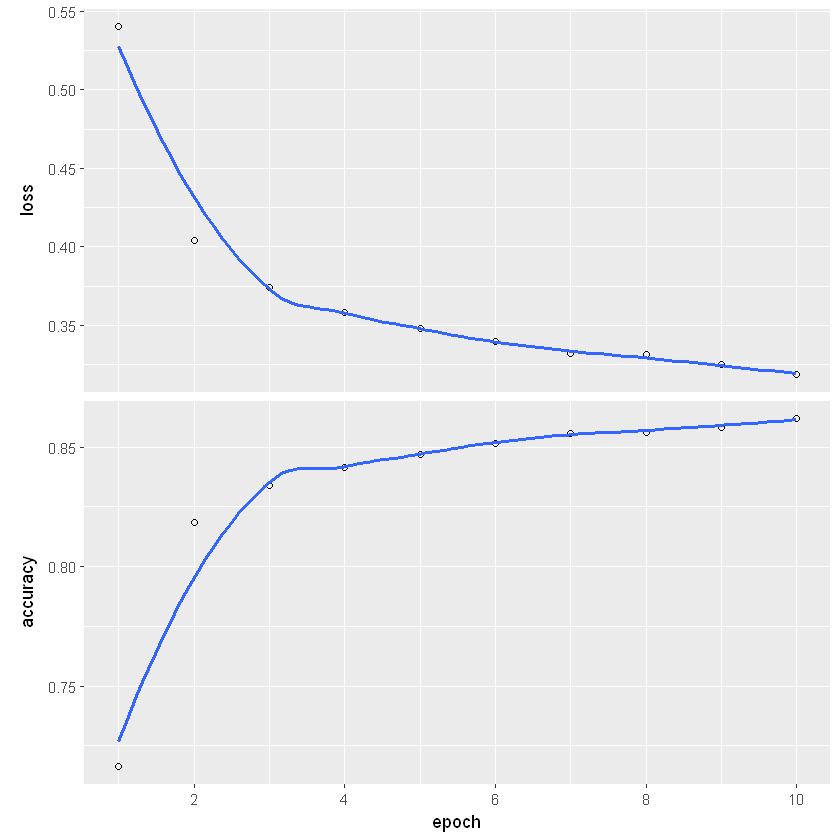

In [55]:
# plot the trend of the loss and accuracy after the training ends
plot(net.train.hist, type="b")

In [56]:
# save the entire model as a binary file
# afterwards we load back the model to perform a cross domain experiment
save_model_hdf5(net, "full_model_imdb_data.hdf5") 

In [57]:
# The following command saves only the weights as a binary file wihout the actual 
#   the model architecture that must be recreated in order to use these weights
save_model_weights_hdf5(net, "weights_model_imdb_data.hdf5")

In [58]:
# definition of a function to perform automatically all the operations above
#  to the input data filename
load.net.data <- function(filename) {
  data <- read.delim(filename)
    labels<- vector()
    texts <- vector()
    n = 1
    for(i in data[,1]){
      m = substr(i,1,10)
      o = substr(i,12,nchar(i))
      labels[n] <- m
      texts[n] <- o
      n = n + 1
    }
  tokens <- tokenize(texts)
  indices <- lapply(tokens, match, vocab$term)
  indices <- lapply(indices, function(s) array(s[!is.na(s),drop=F]-1))
  indices <- pad_sequences(indices, maxlen=max.words)
                    
  label<- vector()
  n = 1
  m = 0
    for(i in labels[]){
      if(grepl("__label__1", i)){
    m = 1
} else{
    m = 2
}
      label[n] <- m
      n = n + 1
    }
  targets <- to_categorical(as.numeric(label)-1)
  list(X=indices, Y=targets)
}

In [59]:
#Loading test set
test <- load.net.data("test.ft.txt")

In [60]:
# Keras provides the evaluate function to estimate the value of the loss function 
#  and of the performance metric (the accuracy) on a test set.
test.eval <- keras::evaluate(net, test$X, test$Y, batch_size=100)

In [61]:
# the accuracy on new amazon reviews is 
test.eval

loss  accuracy 
0.3344921 0.8547185

In [62]:
# Generate predictions (probabilities -- the output of the last layer) on new data using `predict`
y_test_pred <- net %>% predict(test$X[])
head(y_test_pred,10)

[,1]       [,2]      
 [1,] 0.02960723 0.97039276
 [2,] 0.39852098 0.60147905
 [3,] 0.40034866 0.59965134
 [4,] 0.08454300 0.91545701
 [5,] 0.94667494 0.05332502
 [6,] 0.64464134 0.35535872
 [7,] 0.76468343 0.23531654
 [8,] 0.10154533 0.89845467
 [9,] 0.27916962 0.72083044
[10,] 0.02795866 0.97204137

In [63]:
#Testing predict with a custom txt file
datas <- read.delim('myfile.txt')
new_texts <- vector()
 n = 1
    for(i in datas[,1]){
      new_texts[n] <- i
      n = n + 1
    }
new_tokens <- tokenize(new_texts)
new_indices <- lapply(new_tokens, match, vocab$term)
new_indices <- lapply(new_indices, function(s) array(s[!is.na(s),drop=F]-1))
new_indices <- pad_sequences(new_indices, maxlen=max.words)

datas                   

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
y_test_preds <- net %>% predict(new_indices[])
y_test_preds

a               
1 Very good movie.

[,1]      [,2]     
[1,] 0.1164296 0.8835703

In [81]:
#LSA METHOD

In [82]:
#Test to find similar words through LSA method

In [83]:
#Preprocessing
corpus = texts
corpus <- Corpus(VectorSource(corpus))
corpus = tm_map(corpus, tolower)
corpus <- tm_map(corpus, removePunctuation)
corpus <- tm_map(corpus, removeWords, stopwords('english'))

Warning message in tm_map.SimpleCorpus(corpus, tolower):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, removePunctuation):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("english")):
"transformation drops documents"

In [84]:
#Creation of term-document matrix
tdmc <- TermDocumentMatrix(corpus)

In [94]:
inspect( tdmc[ 1:20, 1:20 ] )

<<TermDocumentMatrix (terms: 20, documents: 20)>>
Non-/sparse entries: 50/350
Sparsity           : 88%
Maximal term length: 11
Weighting          : term frequency (tf)
Sample             :
          Docs
Terms      1 14 17 19 2 3 4 5 7 9
  best     2  0  0  0 1 1 1 2 0 0
  buy      1  0  1  1 1 0 0 0 0 0
  ever     1  0  0  0 0 0 0 1 0 0
  every    1  0  0  0 0 0 1 2 0 0
  feel     1  1  1  0 0 0 0 0 0 0
  game     1  0  0  0 2 3 2 1 0 0
  mitsudas 1  0  0  0 0 0 0 2 0 0
  money    1  2  0  0 0 0 0 0 0 0
  much     1  1  0  1 0 0 0 0 1 0
  music    1  0  0  0 2 2 2 1 0 0


In [86]:
tdms <- removeSparseTerms( tdmc, 0.99 )

In [87]:
words <- rownames(tdms)

In [88]:
tdm <- as.matrix(tdms)

In [95]:
tdmle <- lw_logtf(tdm) * ( 1-entropy(tdm) )  
head(tdmle)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. 

1         2         3         4         5         6 7 8 9 10 ... 34887
anything 0.2519862 0.0000000 0.0000000 0.0000000 0.0000000 0 0 0 0 0  ... 0    
best     0.3323751 0.2097053 0.2097053 0.2097053 0.3323751 0 0 0 0 0  ... 0    
bit      0.2479432 0.0000000 0.0000000 0.0000000 0.0000000 0 0 0 0 0  ... 0    
buy      0.2166275 0.2166275 0.0000000 0.0000000 0.0000000 0 0 0 0 0  ... 0    
ever     0.2174926 0.0000000 0.0000000 0.0000000 0.2174926 0 0 0 0 0  ... 0    
every    0.2267877 0.0000000 0.0000000 0.2267877 0.3594499 0 0 0 0 0  ... 0    
         34888 34889 34890     34891 34892 34893 34894 34895 34896
anything 0     0     0.0000000 0     0     0     0     0     0    
best     0     0     0.0000000 0     0     0     0     0     0    
bit      0     0     0.0000000 0     0     0     0     0     0    
buy      0     0     0.0000000 0     0     0     0     0     0    
ever     0     0     0.2174926 0     0     0     0     0     0    
every    0     0     0.0000000 0     0     0     0     0     0

In [90]:
# with this function we compute the norm of a vector
norm_vec <- function(x) sqrt(sum(x^2))

# we use is to compute the norm of each term in the terms-docs matrix 
norma_termini <- apply(tdmle, 1, norm_vec)

# LSA space creation with rank automatically choosen by R
lsar <- lsa( tdmle ) 

# how many eigenvalues have been computed ? 
length(lsar$sk)

[1] 295

In [97]:
# display the 3 matrices of the SVD decomposition: U S V^t
# U is named tk (lsar$tk), S is sk (lsar$sk), V^t is dk (lsar$dk)
head(lsar)

$tk
                       [,1]          [,2]          [,3]          [,4]
anything       -0.043126534 -5.146275e-03  3.727603e-03 -0.0100393073
best           -0.061135965  6.025521e-02  6.373315e-02 -0.0351452372
bit            -0.043190159 -4.509084e-03 -2.405836e-03 -0.0081501072
buy            -0.060411596  1.757088e-02  5.229435e-02 -0.1127200627
ever           -0.056361096  5.759912e-02  4.796314e-02  0.0127931509
every          -0.050692185  1.962994e-02  4.019858e-03 -0.0294968055
feel           -0.044670714  8.937455e-03 -1.633819e-03 -0.0040356624
game           -0.040780253 -2.784310e-02  2.711198e-03 -0.0199794473
going          -0.048418669  1.516528e-02  1.014144e-02 -0.0122946762
listening      -0.028248973 -2.700862e-02 -5.621861e-03 -0.0310989113
lot            -0.048515963  1.916360e-02 -1.274052e-03 -0.0078886313
masterpiece    -0.021652338 -7.912304e-03  2.410874e-03  0.0379976907
money          -0.054191814  5.239870e-03  2.460295e-02 -0.0615562736
much           -0.062989756  8.481341e-02  3.242332e-02 -0.0401364690
music          -0.056821204 -2.642122e-02  7.168702e-02 -0.1188877845
must           -0.050509416  1.386899e-02  4.369527e-03  0.0128327703
now            -0.056499560  1.941545e-02  2.005122e-02 -0.0751637755
one            -0.075417019  2.236364e-01  1.305779e-01 -0.1331505473
pretty         -0.044511719 -4.780845e-03  2.309367e-02 -0.0182728536
price          -0.043726676 -2.057267e-02 -6.429319e-04 -0.0716298957
reading        -0.050766284  9.683882e-02 -1.164606e-01  0.0473535140
review         -0.043525869  2.289700e-04 -1.349762e-02  0.0055775724
reviews        -0.043805881 -2.212331e-03 -7.947121e-03 -0.0227192066
say            -0.053039426  3.359468e-02  2.449426e-02 -0.0172089049
saying         -0.026026558 -1.604602e-02 -6.539929e-03  0.0164778056
simply         -0.037248076 -1.039563e-02 -2.457440e-03  0.0125615774
worth          -0.050001538  6.006962e-03  1.792893e-02 -0.0235422594
write          -0.032560939 -1.002687e-03 -2.796513e-02  0.0182661395
years          -0.051581463  2.791584e-02 -1.040616e-03 -0.0297550944
absolutely     -0.034267563 -1.195472e-02  4.691953e-03  0.0192443136
amazing        -0.038961407 -7.902077e-03 -4.040265e-03  0.0148024593
cant           -0.052871112  1.504537e-02  2.895558e-02 -0.0268166847
even           -0.063292703  7.168852e-02  5.836083e-02 -0.0493721312
favorite       -0.043721501  4.275170e-04  2.217221e-02  0.0065445981
girl           -0.027401196 -1.361310e-02 -1.771760e-03  0.0298250798
give           -0.048663497  1.619578e-02  1.318070e-02 -0.0139033803
hands          -0.021031521 -1.872876e-02 -1.307642e-02  0.0151429345
havent         -0.030914403 -1.386804e-02 -1.922254e-03  0.0037515215
heard          -0.040576011 -1.927540e-02  1.405560e-02 -0.0315302318
hope           -0.035720187 -8.662354e-03 -1.946737e-03  0.0060364217
important      -0.027674004 -7.465022e-03 -2.618645e-02  0.0139428371
like           -0.074370205  1.833704e-01  1.111631e-01 -0.1082584489
means          -0.022346404 -1.538652e-02 -9.752593e-03  0.0058945467
never          -0.056895838  3.953001e-02  1.917086e-02 -0.0233326887
played         -0.032423184 -2.771193e-02  1.032832e-02 -0.0066606398
probably       -0.039903557 -2.599812e-03  3.671657e-03 -0.0023338291
star           -0.038886110 -2.290561e-03  2.815878e-02  0.0277749507
stars          -0.044331600 -3.898408e-03  2.165083e-02  0.0135616643
sure           -0.043739326 -2.497448e-03  7.261505e-03 -0.0188882293
throughout     -0.025907641 -8.096949e-03 -1.213530e-02  0.0319406317
time           -0.065788013  1.125632e-01  5.312449e-02 -0.0609502941
times          -0.047068057  1.342321e-02  3.877954e-03  0.0020139034
tracks         -0.029619688 -3.412470e-02 -2.604158e-04 -0.0479152162
twice          -0.022760732 -2.195818e-02 -1.078740e-02  0.0013622490
wish           -0.039750656 -1.282186e-02 -6.405816e-03  0.0025581959
work           -0.055002615  1.474466e-02 -8.778052e-03 -0.0726483965
youve 

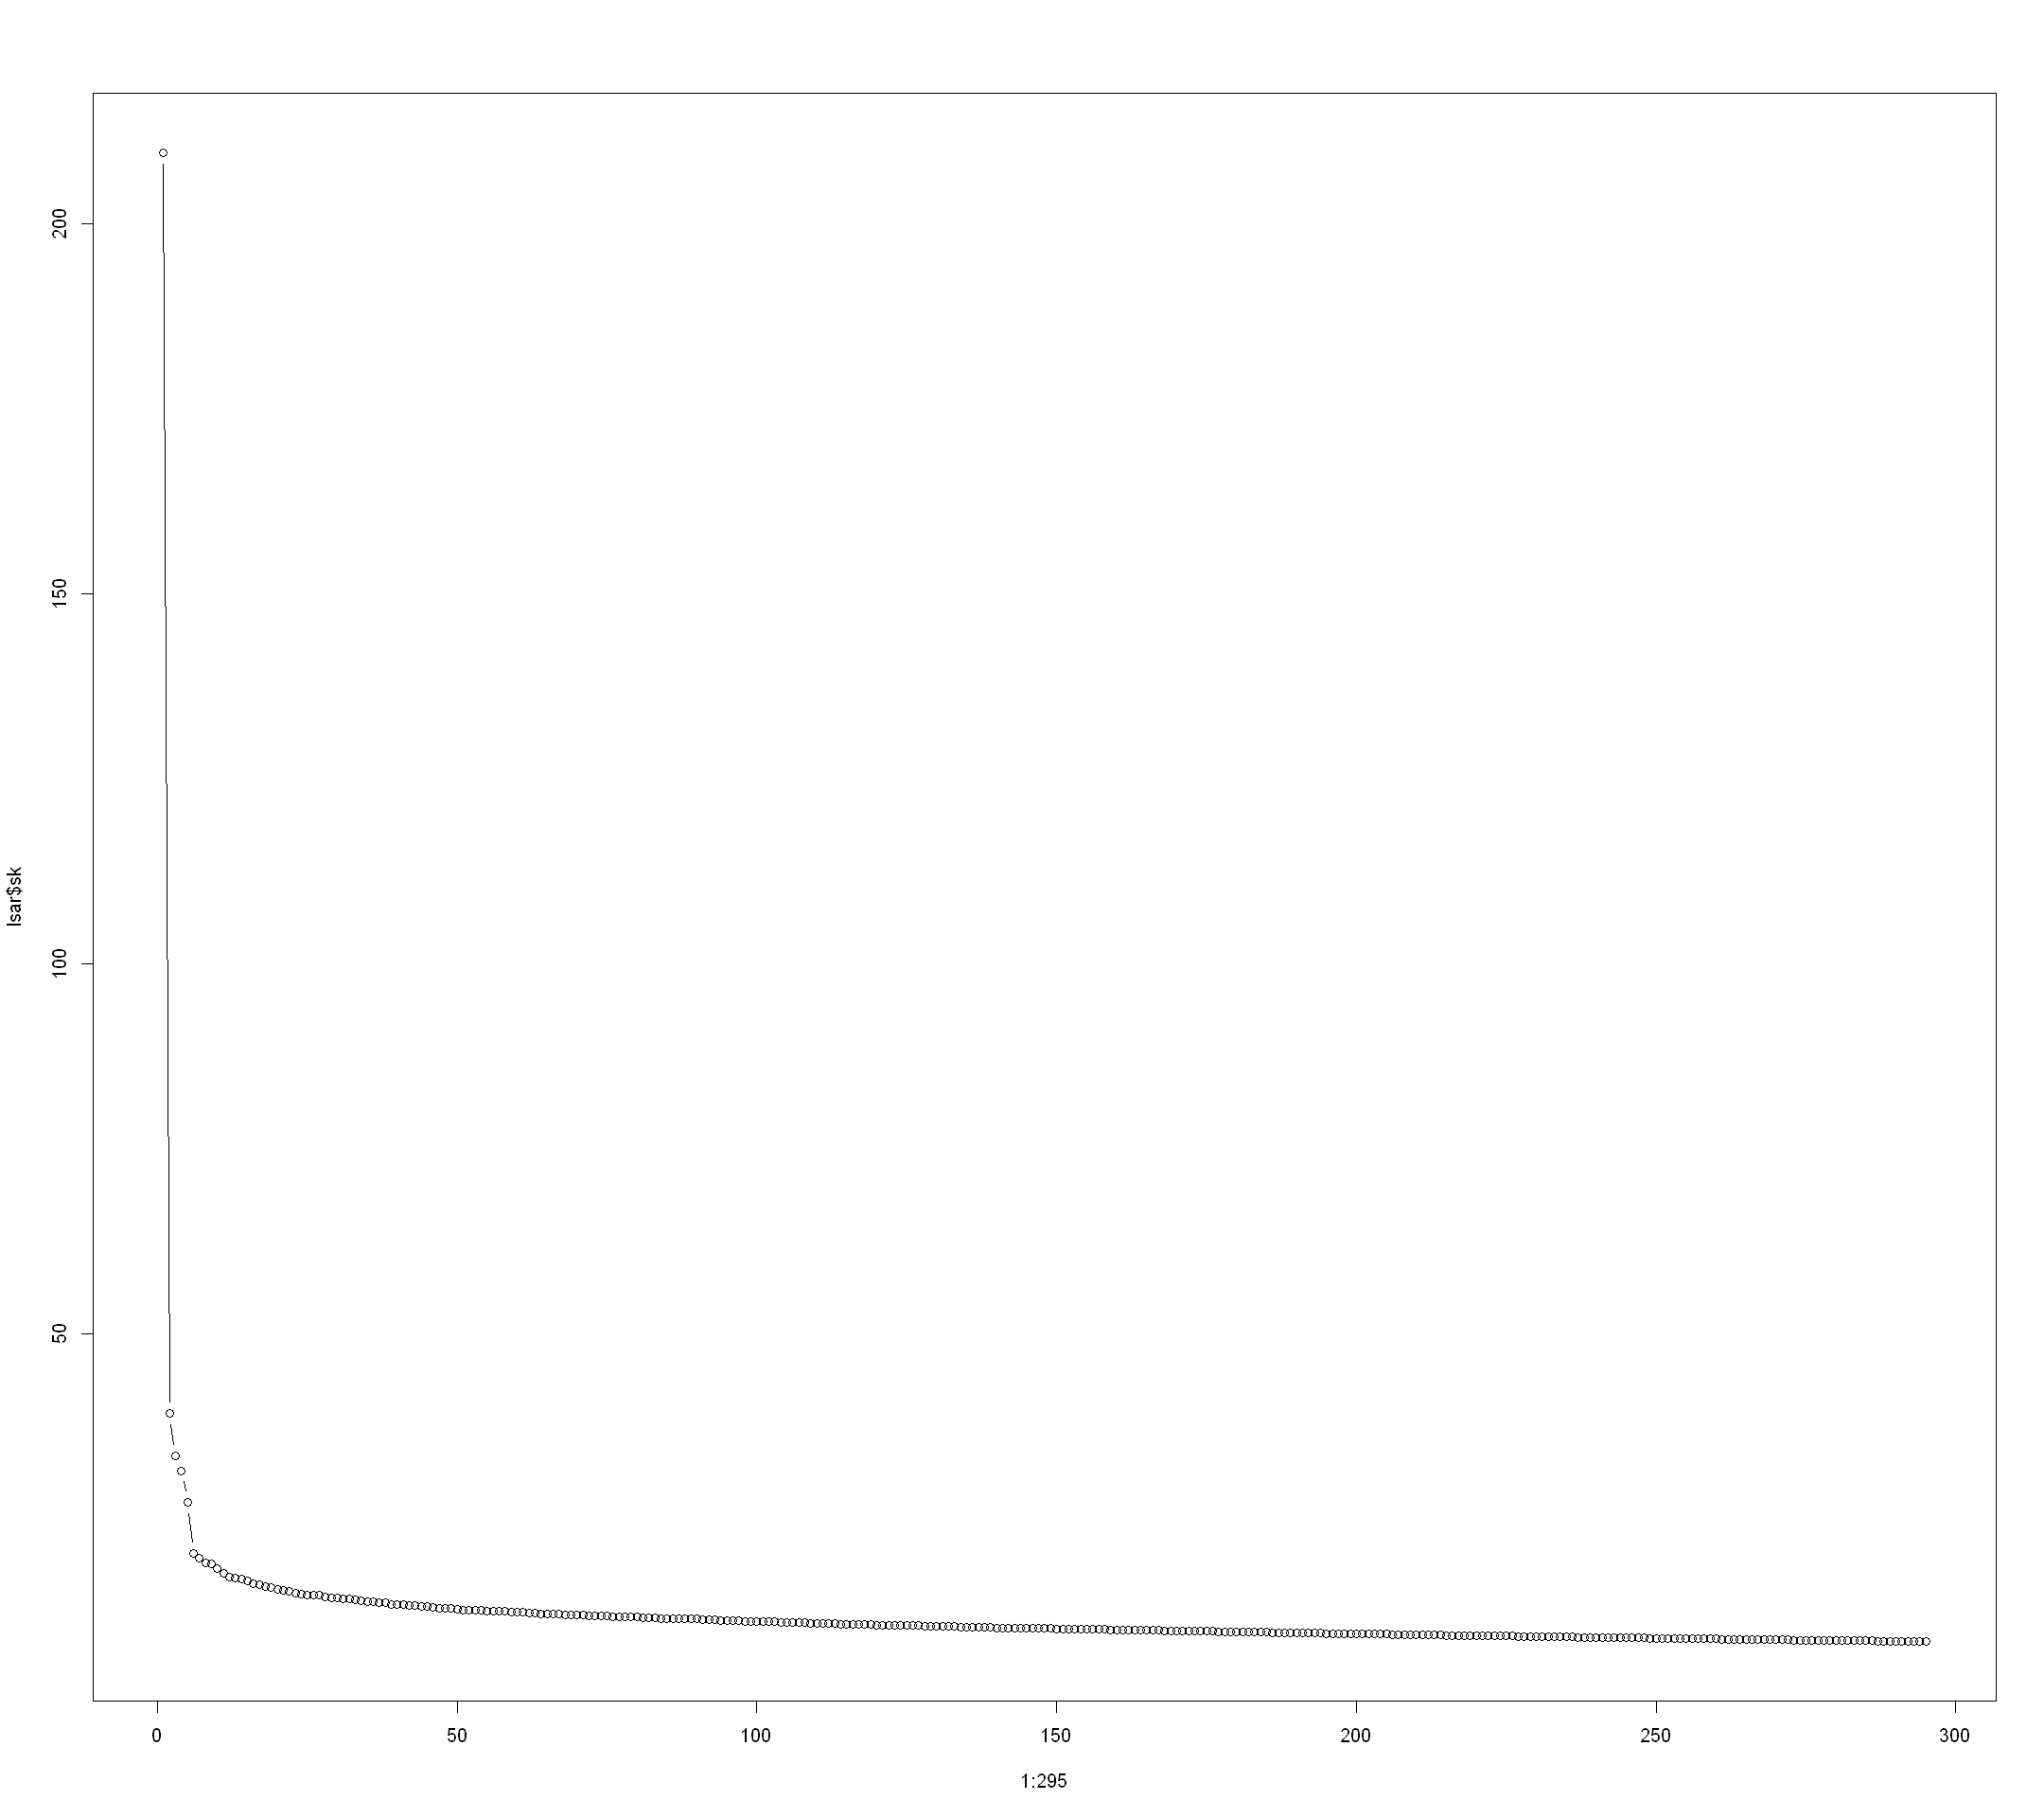

In [119]:
# graphs of the eigenvalues computed by the SVD 
plot( 1:295, lsar$sk, type="b" )

In [99]:
# let's compute the two weighted matrices, terms and docs, of semantic similarity by the eigenvalues
tls <- lsar$tk %*% diag( lsar$sk )
dls <- lsar$dk %*% diag( lsar$sk )

In [100]:
# compute the norm of each term 
norma_termini_lsa <- apply(tls, 1, norm_vec)
# add the column of the norms to the matrix tls, we need this in the next operations
tls_norma_termini = cbind(tls, norma_termini_lsa)

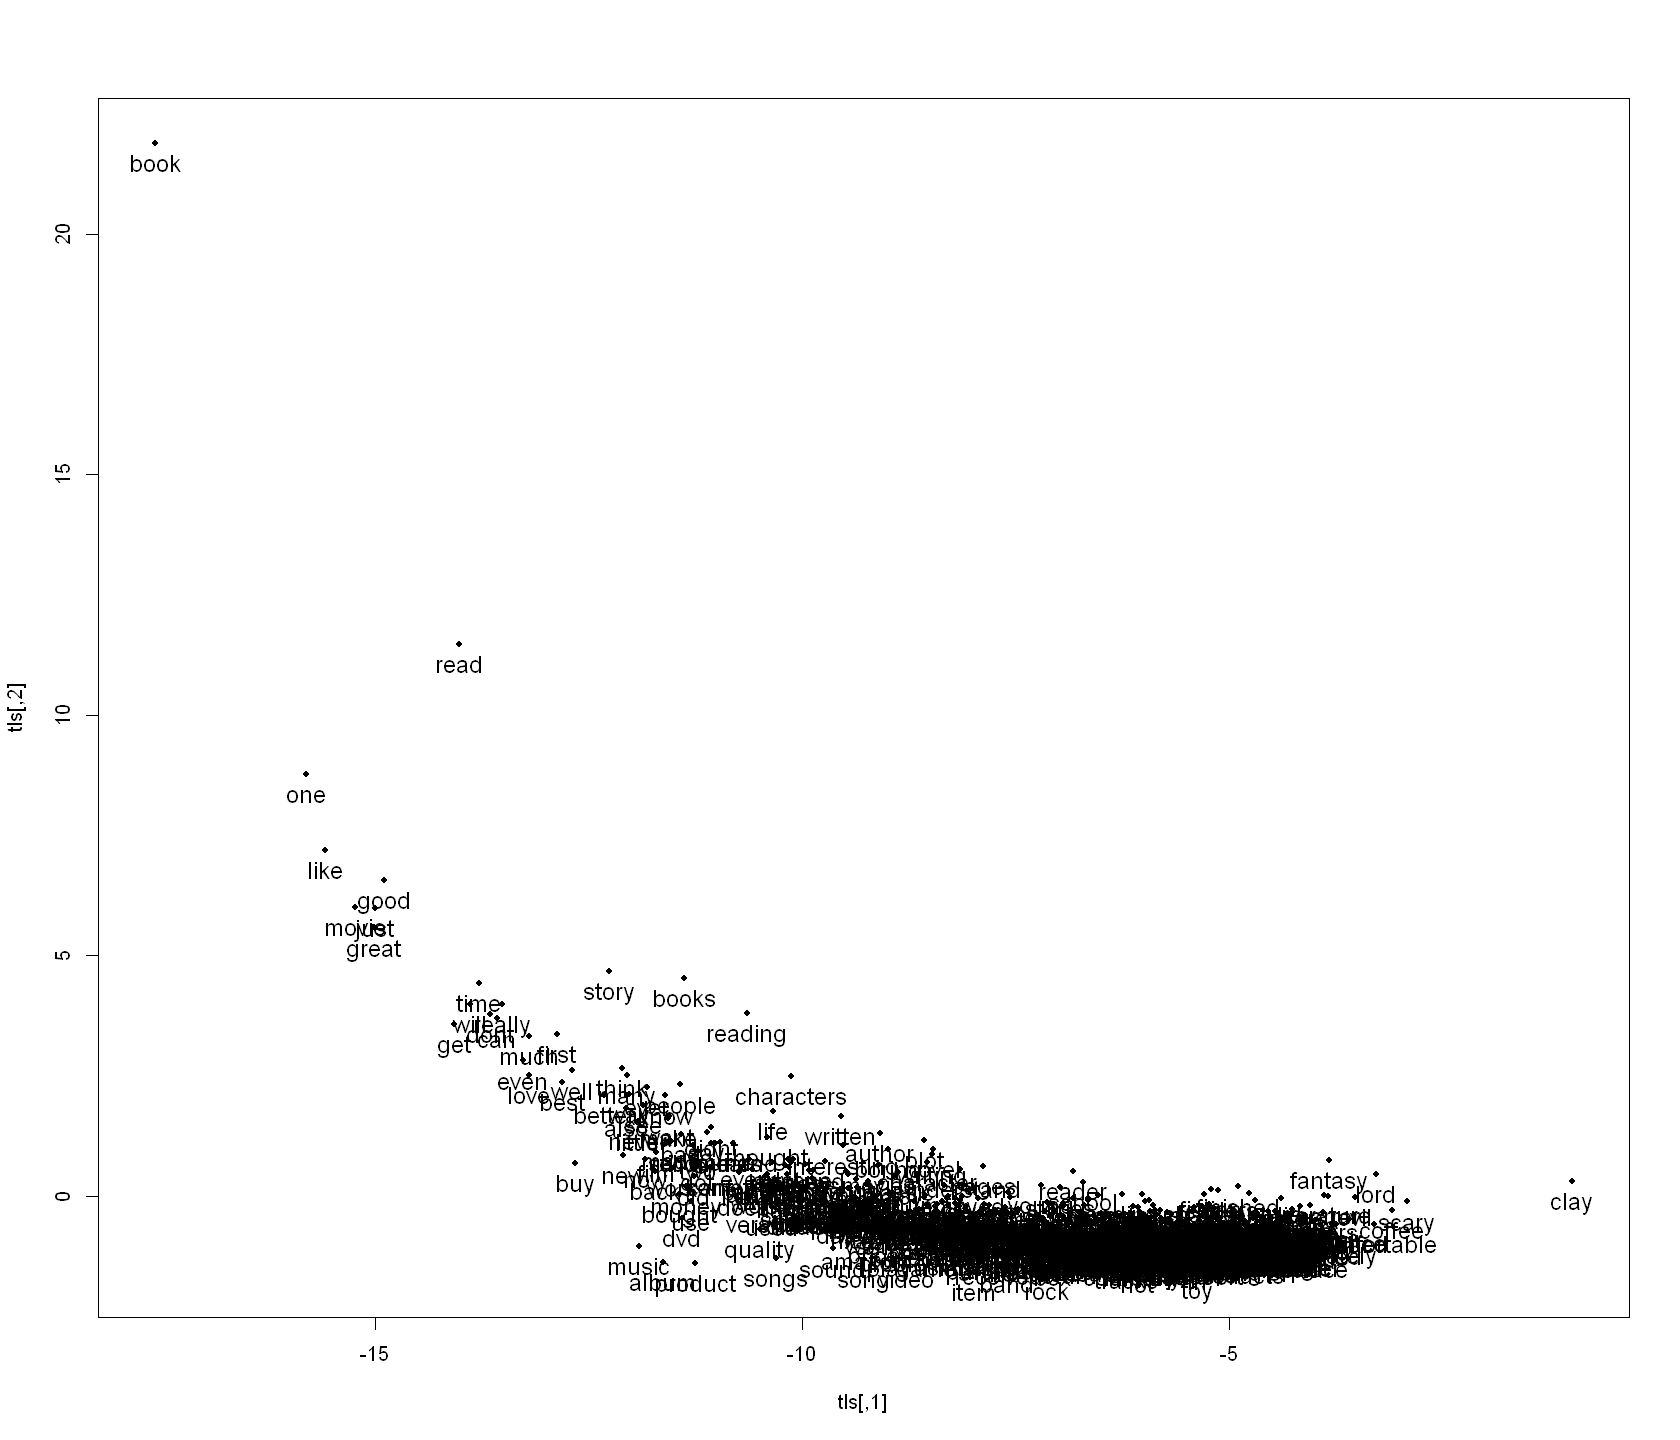

In [101]:
# graphic representation of terms using the first two latent dimensions
options(repr.plot.width=14, repr.plot.height=12)
plot( tls, pch=20 )
text( tls, labels=words, cex=1.2, pos=1 )
#dev.off()

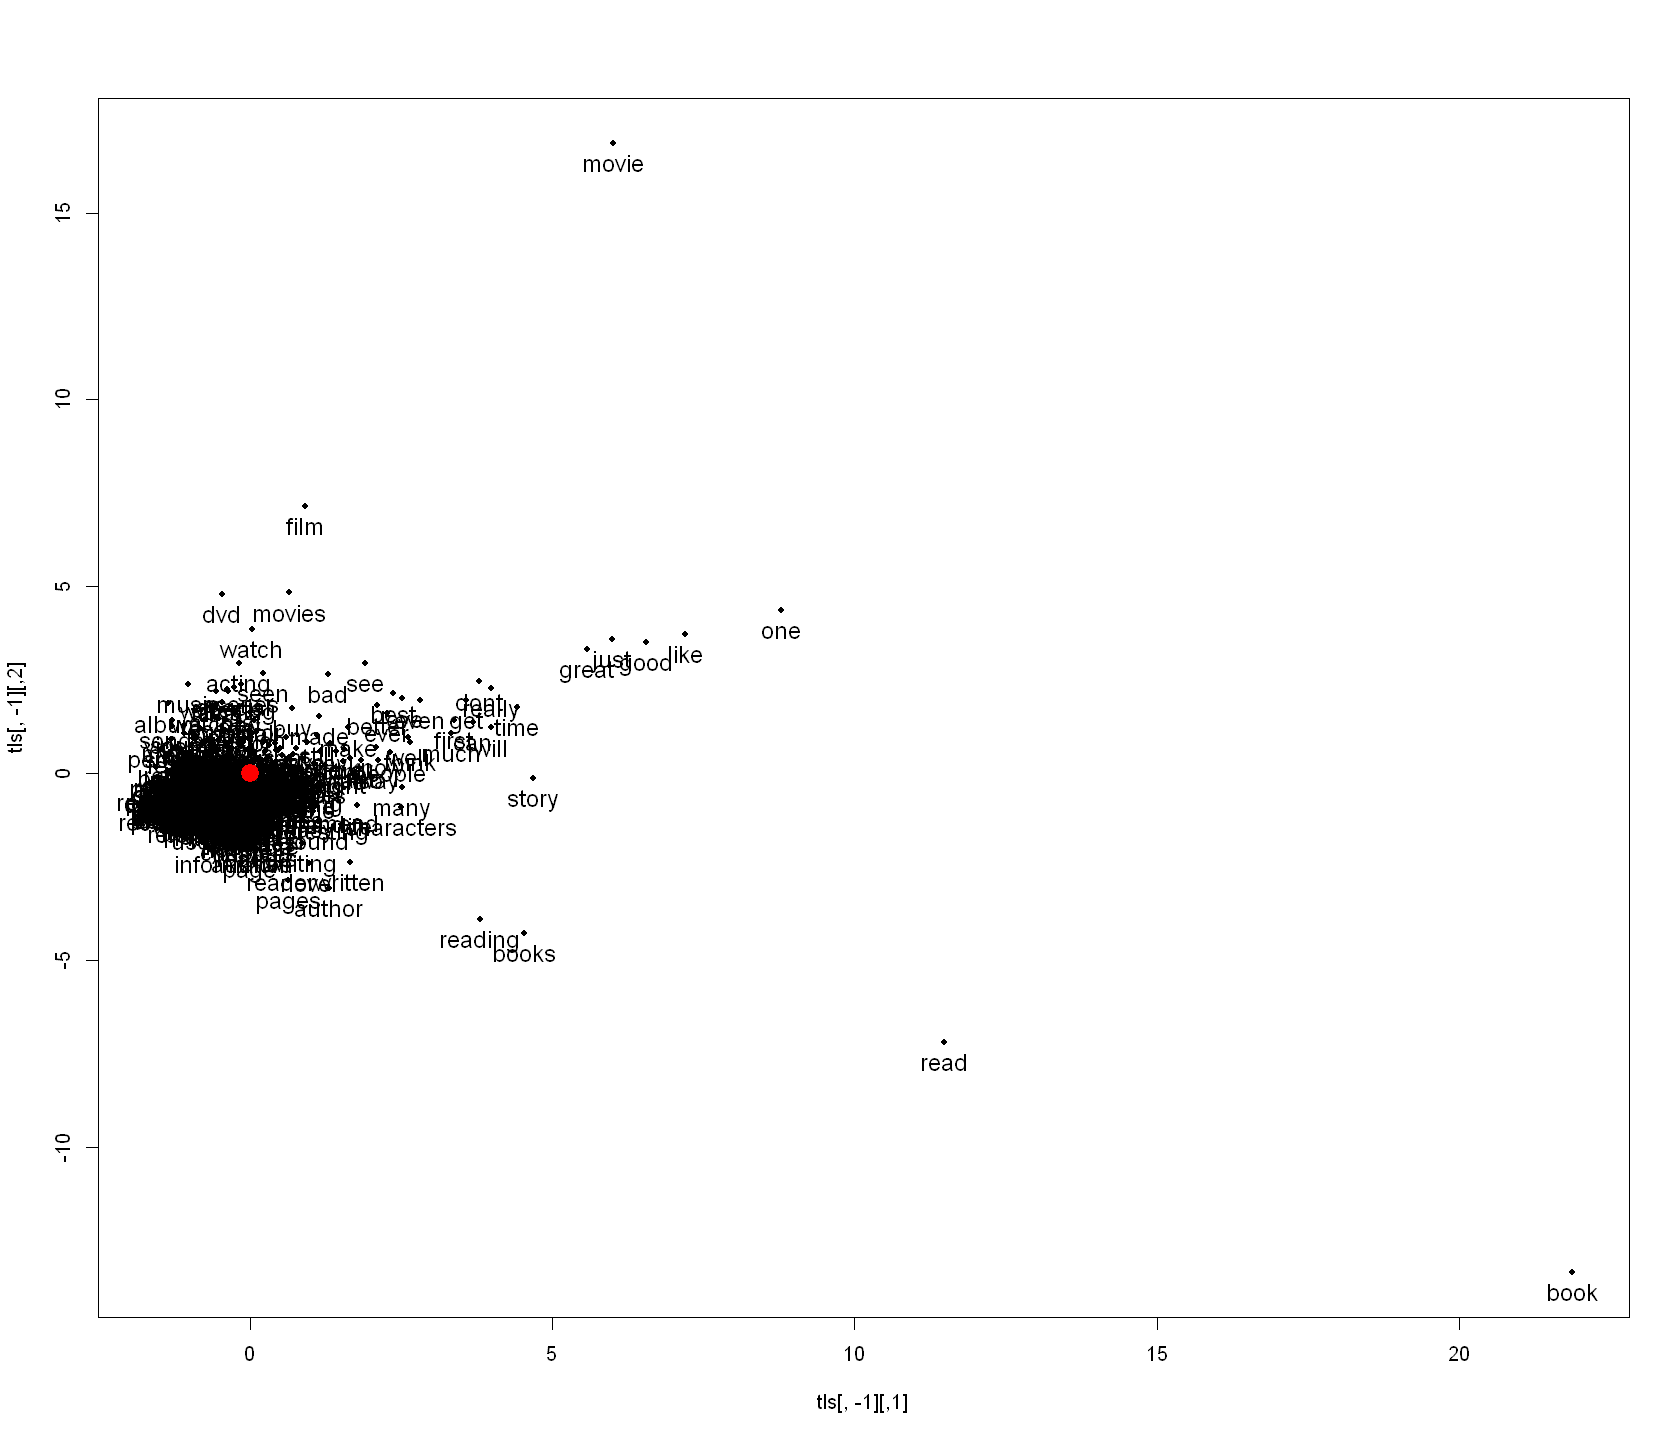

In [103]:
# graph representation of the terms using the second and third latent variables
options(repr.plot.width=14, repr.plot.height=12)
plot( tls[,-1], pch=20 ) # -1 removes the first latent dimensions in order to display 2° and 3°
text( tls[,-1], labels=words, cex=1.2, pos=1 )
points( 0, 0, pch=20, cex=3, col="red" ) # draw the origin 0,0 of the cartesian plane
#dev.off()

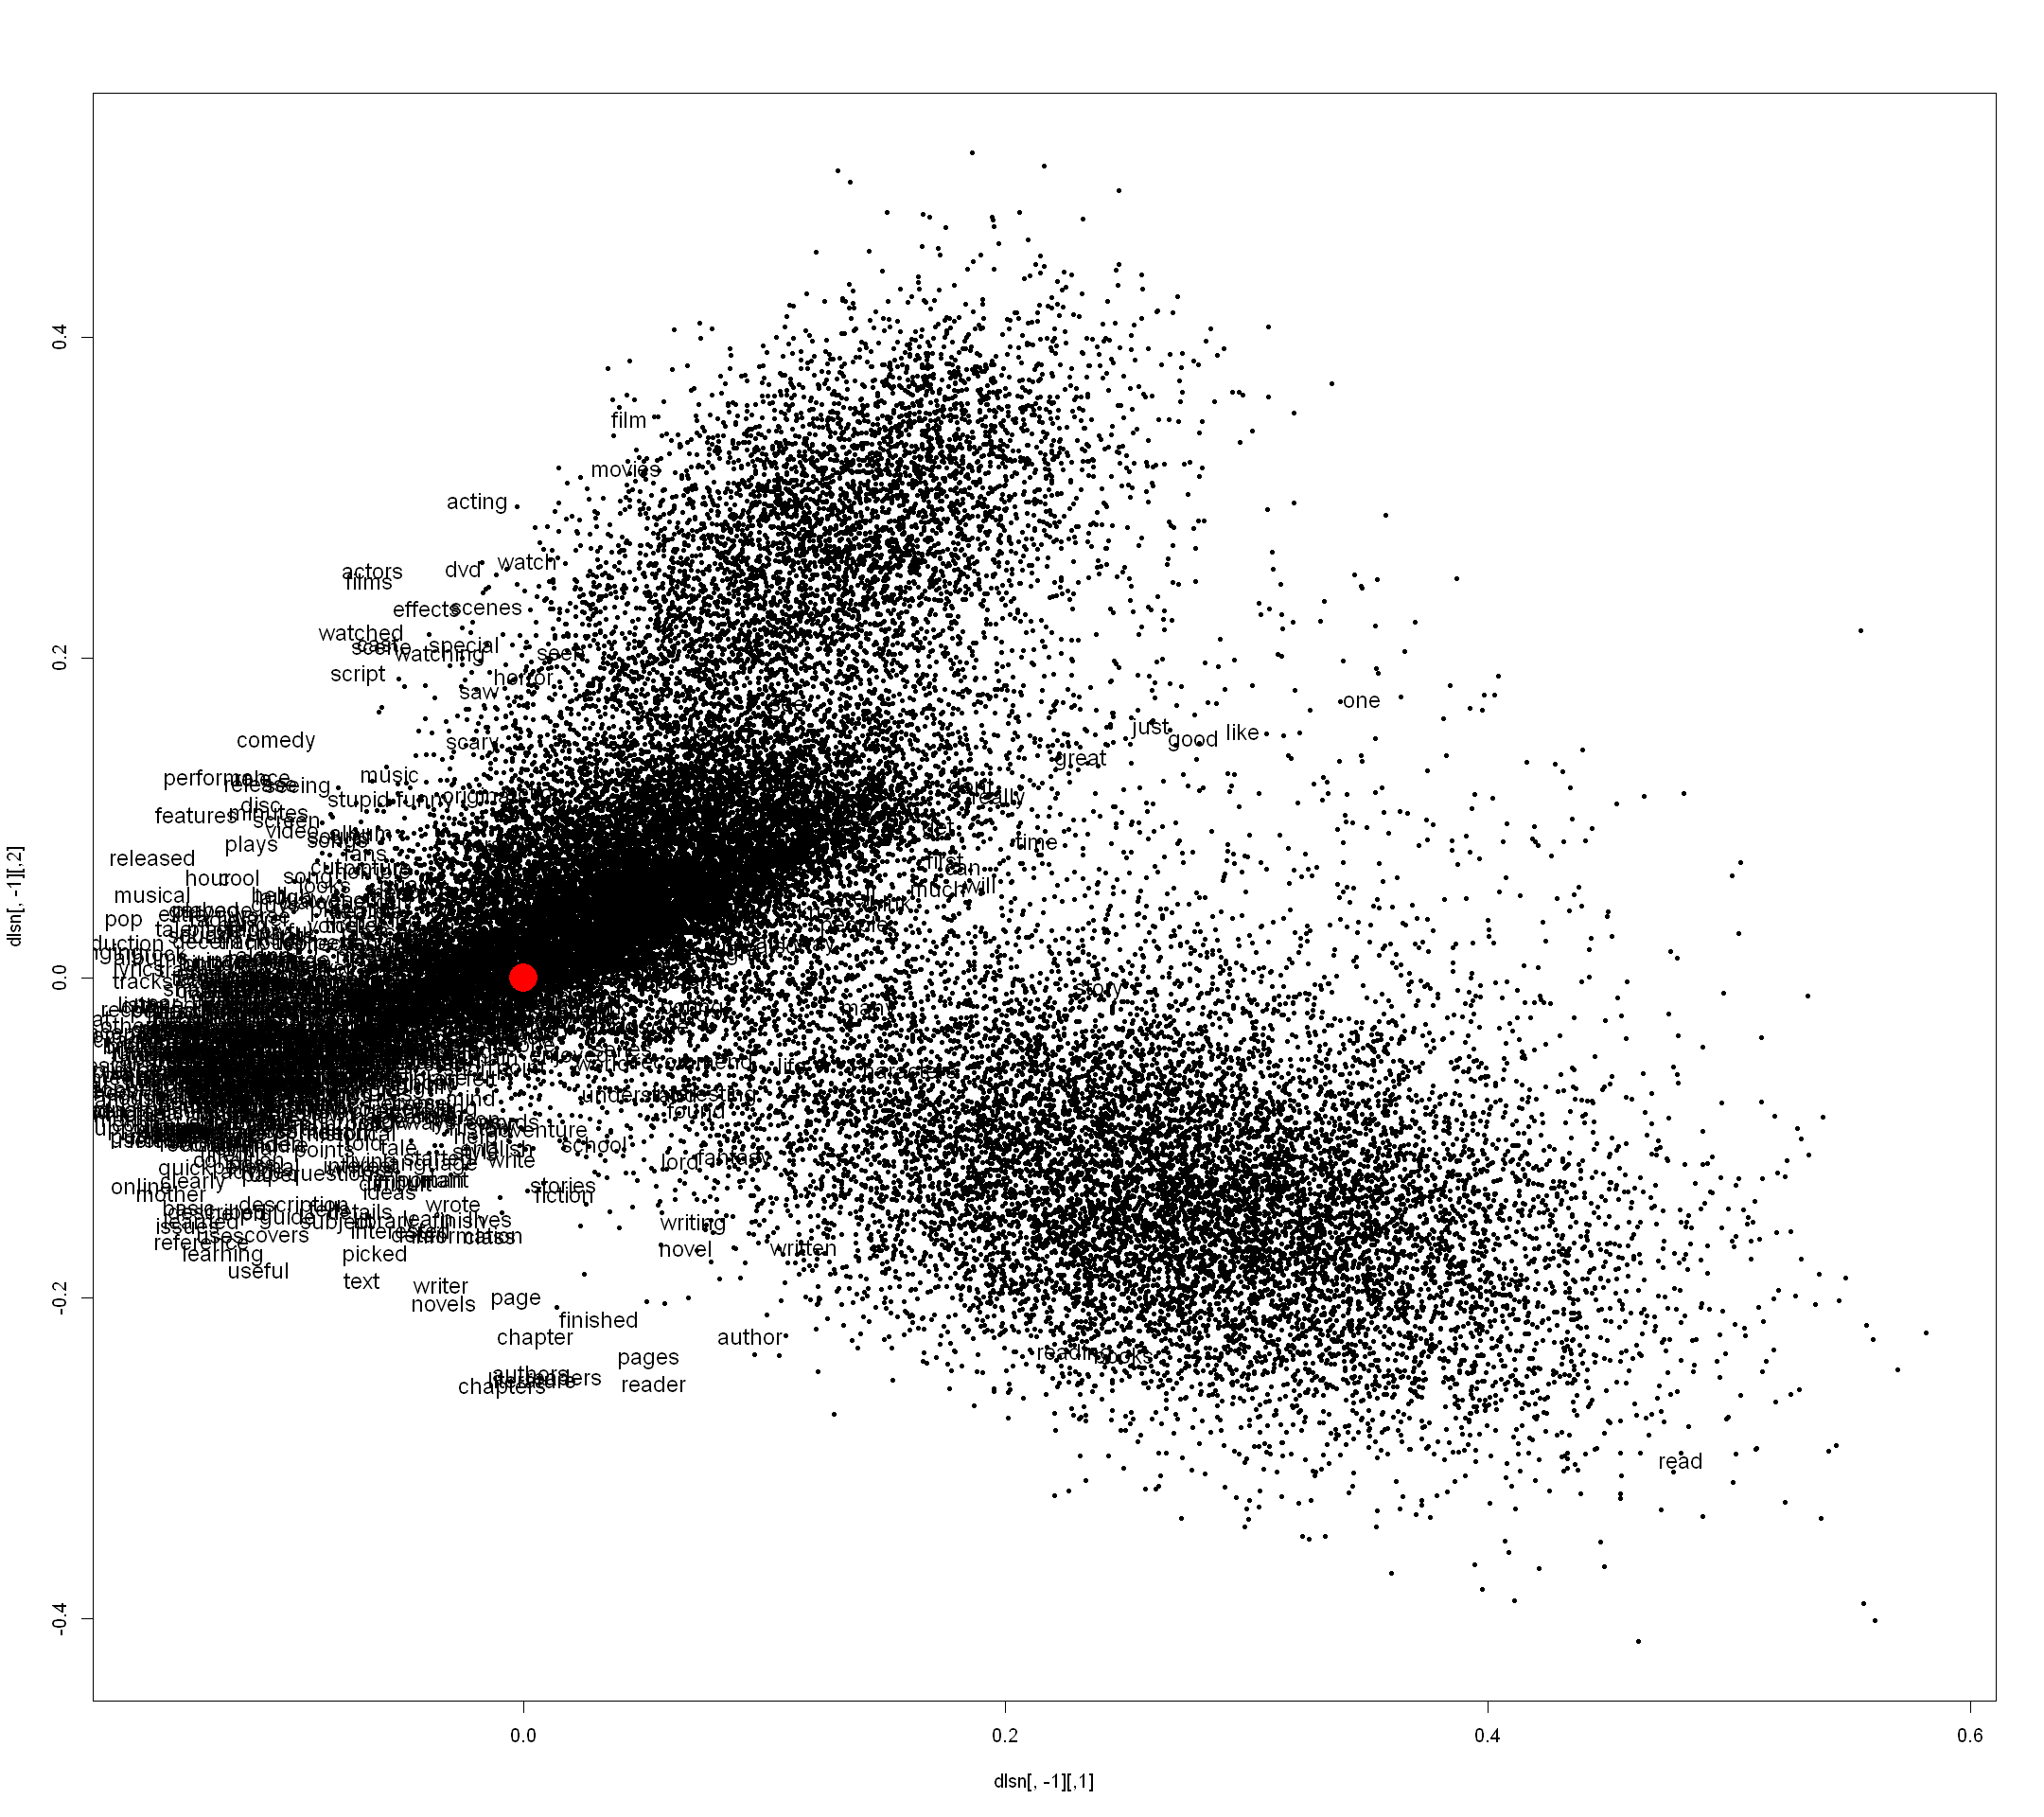

In [104]:
#dev.off()
# definition and application of the function for the normalization of terms and docs vectors 
# in fact the vectors tls and dls are not normal because achieved by the product with sk (eigenvalues matrix) 
normrows <- function(x) x / apply(x,1,norm,"2")
tlsn <- normrows(tls)
dlsn <- normrows(dls)

# new graph with normalized vectors of terms and docs
options(repr.plot.width=18, repr.plot.height=16)
plot( dlsn[,-1], pch=20, cex=0.8)
text( tlsn[,-1], labels=words, cex=1.2 )
points( 0, 0, pch=20, cex=5, col="red" )

In [105]:
# let's find the semantically closest term to book in the LSA space
associate(tls[,2:3], "book", threshold=0.8)

anyone        read   wonderful        work   recommend        life 
  0.9999736   0.9999285   0.9990751   0.9969428   0.9968108   0.9957028 
     things         put       loved     however  characters       books 
  0.9931366   0.9930568   0.9911107   0.9834860   0.9798487   0.9782441 
interesting   excellent        find     reading       young      series 
  0.9760296   0.9717626   0.9708930   0.9689277   0.9661446   0.9659875 
     ending        last      boring       found     fantasy        take 
  0.9653354   0.9614122   0.9590026   0.9546105   0.9352299   0.9302022 
       feel        many     written  understand       world     looking 
  0.9237189   0.9187160   0.9150971   0.9101394   0.8953418   0.8875033 
        lot        lord       years       story   character     writing 
  0.8818405   0.8754011   0.8698594   0.8677541   0.8616561   0.8308620 
     author       novel 
  0.8123594   0.8012368

In [106]:
# le'ts repeat the analysis in the LSA space, to evaluate if there exists SEMANTIC correlation  
# between the couple of terms "terrible book" and the other documents.
# In this case the considered docs could also not contain the two terms, but they may contain 
# semantically correlated terms to them.
# To peform this analysis let's transform the query "terrible book" in a doc and do the fold_in in the 
# LSA spaces
awq <- "terrible book"
awv <- query( awq, words )
awle <- lw_logtf(awv) * ( 1-entropy(tdm) )
awls <- t(awle) %*% lsar$tk
awls

[,1]        [,2]       [,3]        [,4]       [,5]        
TERRIBLE BOOK -0.02456415 0.09423634 -0.06716824 0.01952648 -0.001926146
              [,6]       [,7]       [,8]        [,9]         [,10]      [,11]
TERRIBLE BOOK 0.03035027 0.09190288 -0.01288564 -0.003690572 0.01755647 ...  
              [,12]       [,13]       [,14]       [,15]        [,16]     
TERRIBLE BOOK -0.01041647 -0.02398822 -0.02005979 0.0003648579 0.01415245
              [,17]       [,18]       [,19]      [,20]      [,21]      
TERRIBLE BOOK 0.009117558 -0.03294598 0.01294832 0.02134681 -0.02457733

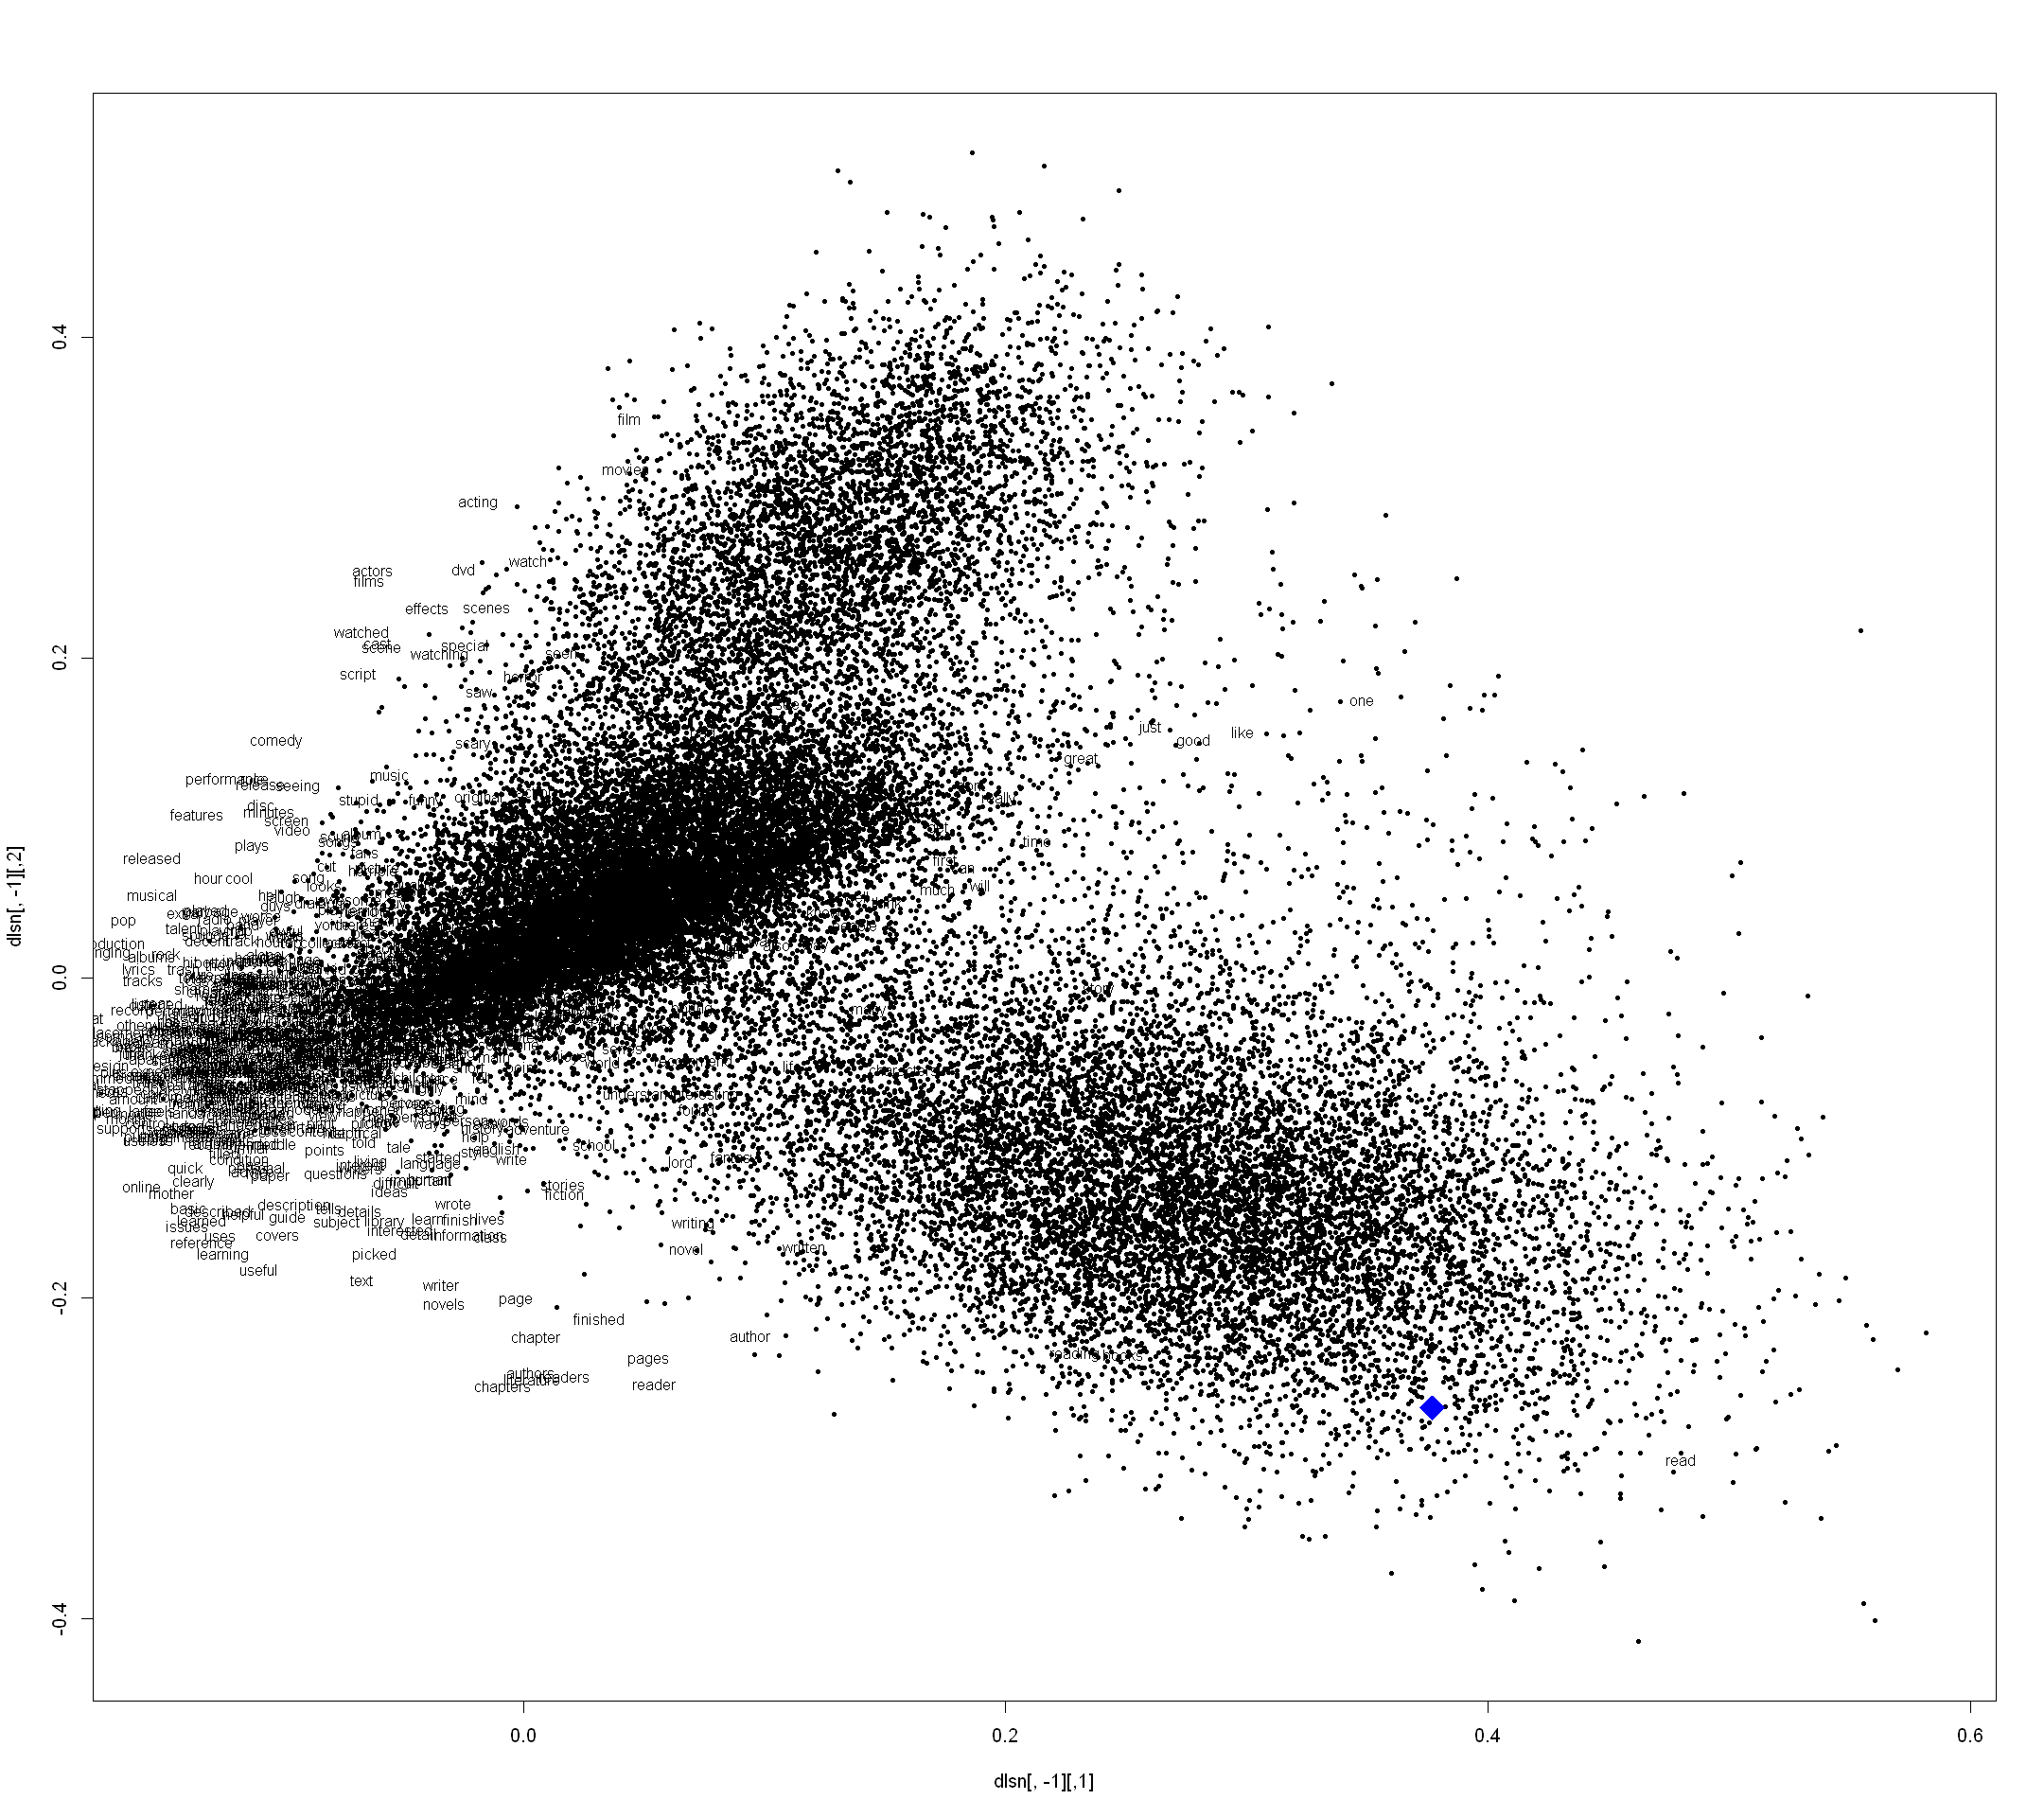

In [107]:
# graph of the terms and docs in the LSA space using the dimensions 2 and 3
plot( dlsn[,-1], pch=20, cex=0.8)
text( tlsn[,-1], labels=words, cex=0.8 )
points( 0, 0, pch=20, cex=3 )  # display the origin 0,0 of the graph 
awlsn <- normrows( awls ) # vector query normalization 
points(awlsn[2],awlsn[3],cex=3,pch=18,col="blue") # display of the query in the graph 

In [108]:
# definizione funzione che restituisce un vettore con le similarità coseno tra il vettore Q
# e le righe della matrice X
cosines <- function(X, Q) apply( X, 1, cosine, as.vector(Q) )
# definizione funzione che restituisce gli indici (i.e. posizioni) degli N valori più elevati in X 
top <- function(X, N) order( X, decreasing=TRUE )[1:N]

In [109]:
# indice dei 10 documenti che risultano semanticamente piu' simili alla query "terrible book"
# considerando solo la dimensione 2 e 3
top( cosines( dls[,2:3], awls[2:3] ), 10 )
# elenco dei 10 documenti sopra menzionati 
texts[top(cosines(dls[,2:3], awls[2:3]), 10)]
# tra i documenti ci sono recensioni dove non e' sempre inerente la query in questione
# quindi con due sole dimensioni LSA la perdita d'informazione e' significativa  

[1] 10901  3729 14861   466 22599 11900  4769 11929 22358  3618

[1] "Intellectual Garbage: C.S. Lewis does a diservice to Christianity in this book. His views are narrow and his explanations both condescending and banal. The statement that Jesus can be only the son of God, or one of a demon is ridiculous and serves only to keep himself feeling safe. He ignores scripture by stating this. All things I have done, you can do also and more.... He ignores what does not fit his preconceived notions and speaks primarily to and for old women wanting the assertions that they have always believed in validated by an intellectual. He takes no risks in this. He does not stretch his mind, or the reader's imagination. It's old dogma spoken in a modern and rational language. It's dull in the extreme."                                                                                                                                                                                                                                           
 [2] "A marvelous, splendid gift on the Catholic Faith: The book A Philadelphia Catholic in King James's Court is marvelous, a splendid gift for setting forth the truths of our Catholic faith clearly and precisely. And oh, how this is needed in these times of crisis and confusion in church catechesis. A must read for every Catholic of all ages, religious and clergy included, and a great book to share."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [3] "Total Puff Piece: If you believe the picture painted in this book about Kerry, I have a bridge for sale. This is a complete puff piece that no self respecting Historian would publish. Read Unfit for Command to get the truth!"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
 [4] "Not what I was anticipating: Thought it was a picture book of the Fiords.... That's what happens sometimes when you cannot actually touch a book..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
 [5] "Please Amazon, No Spoilers!: I am not finished reading this book, but I will give it 5 stars anyway. What I object to is br

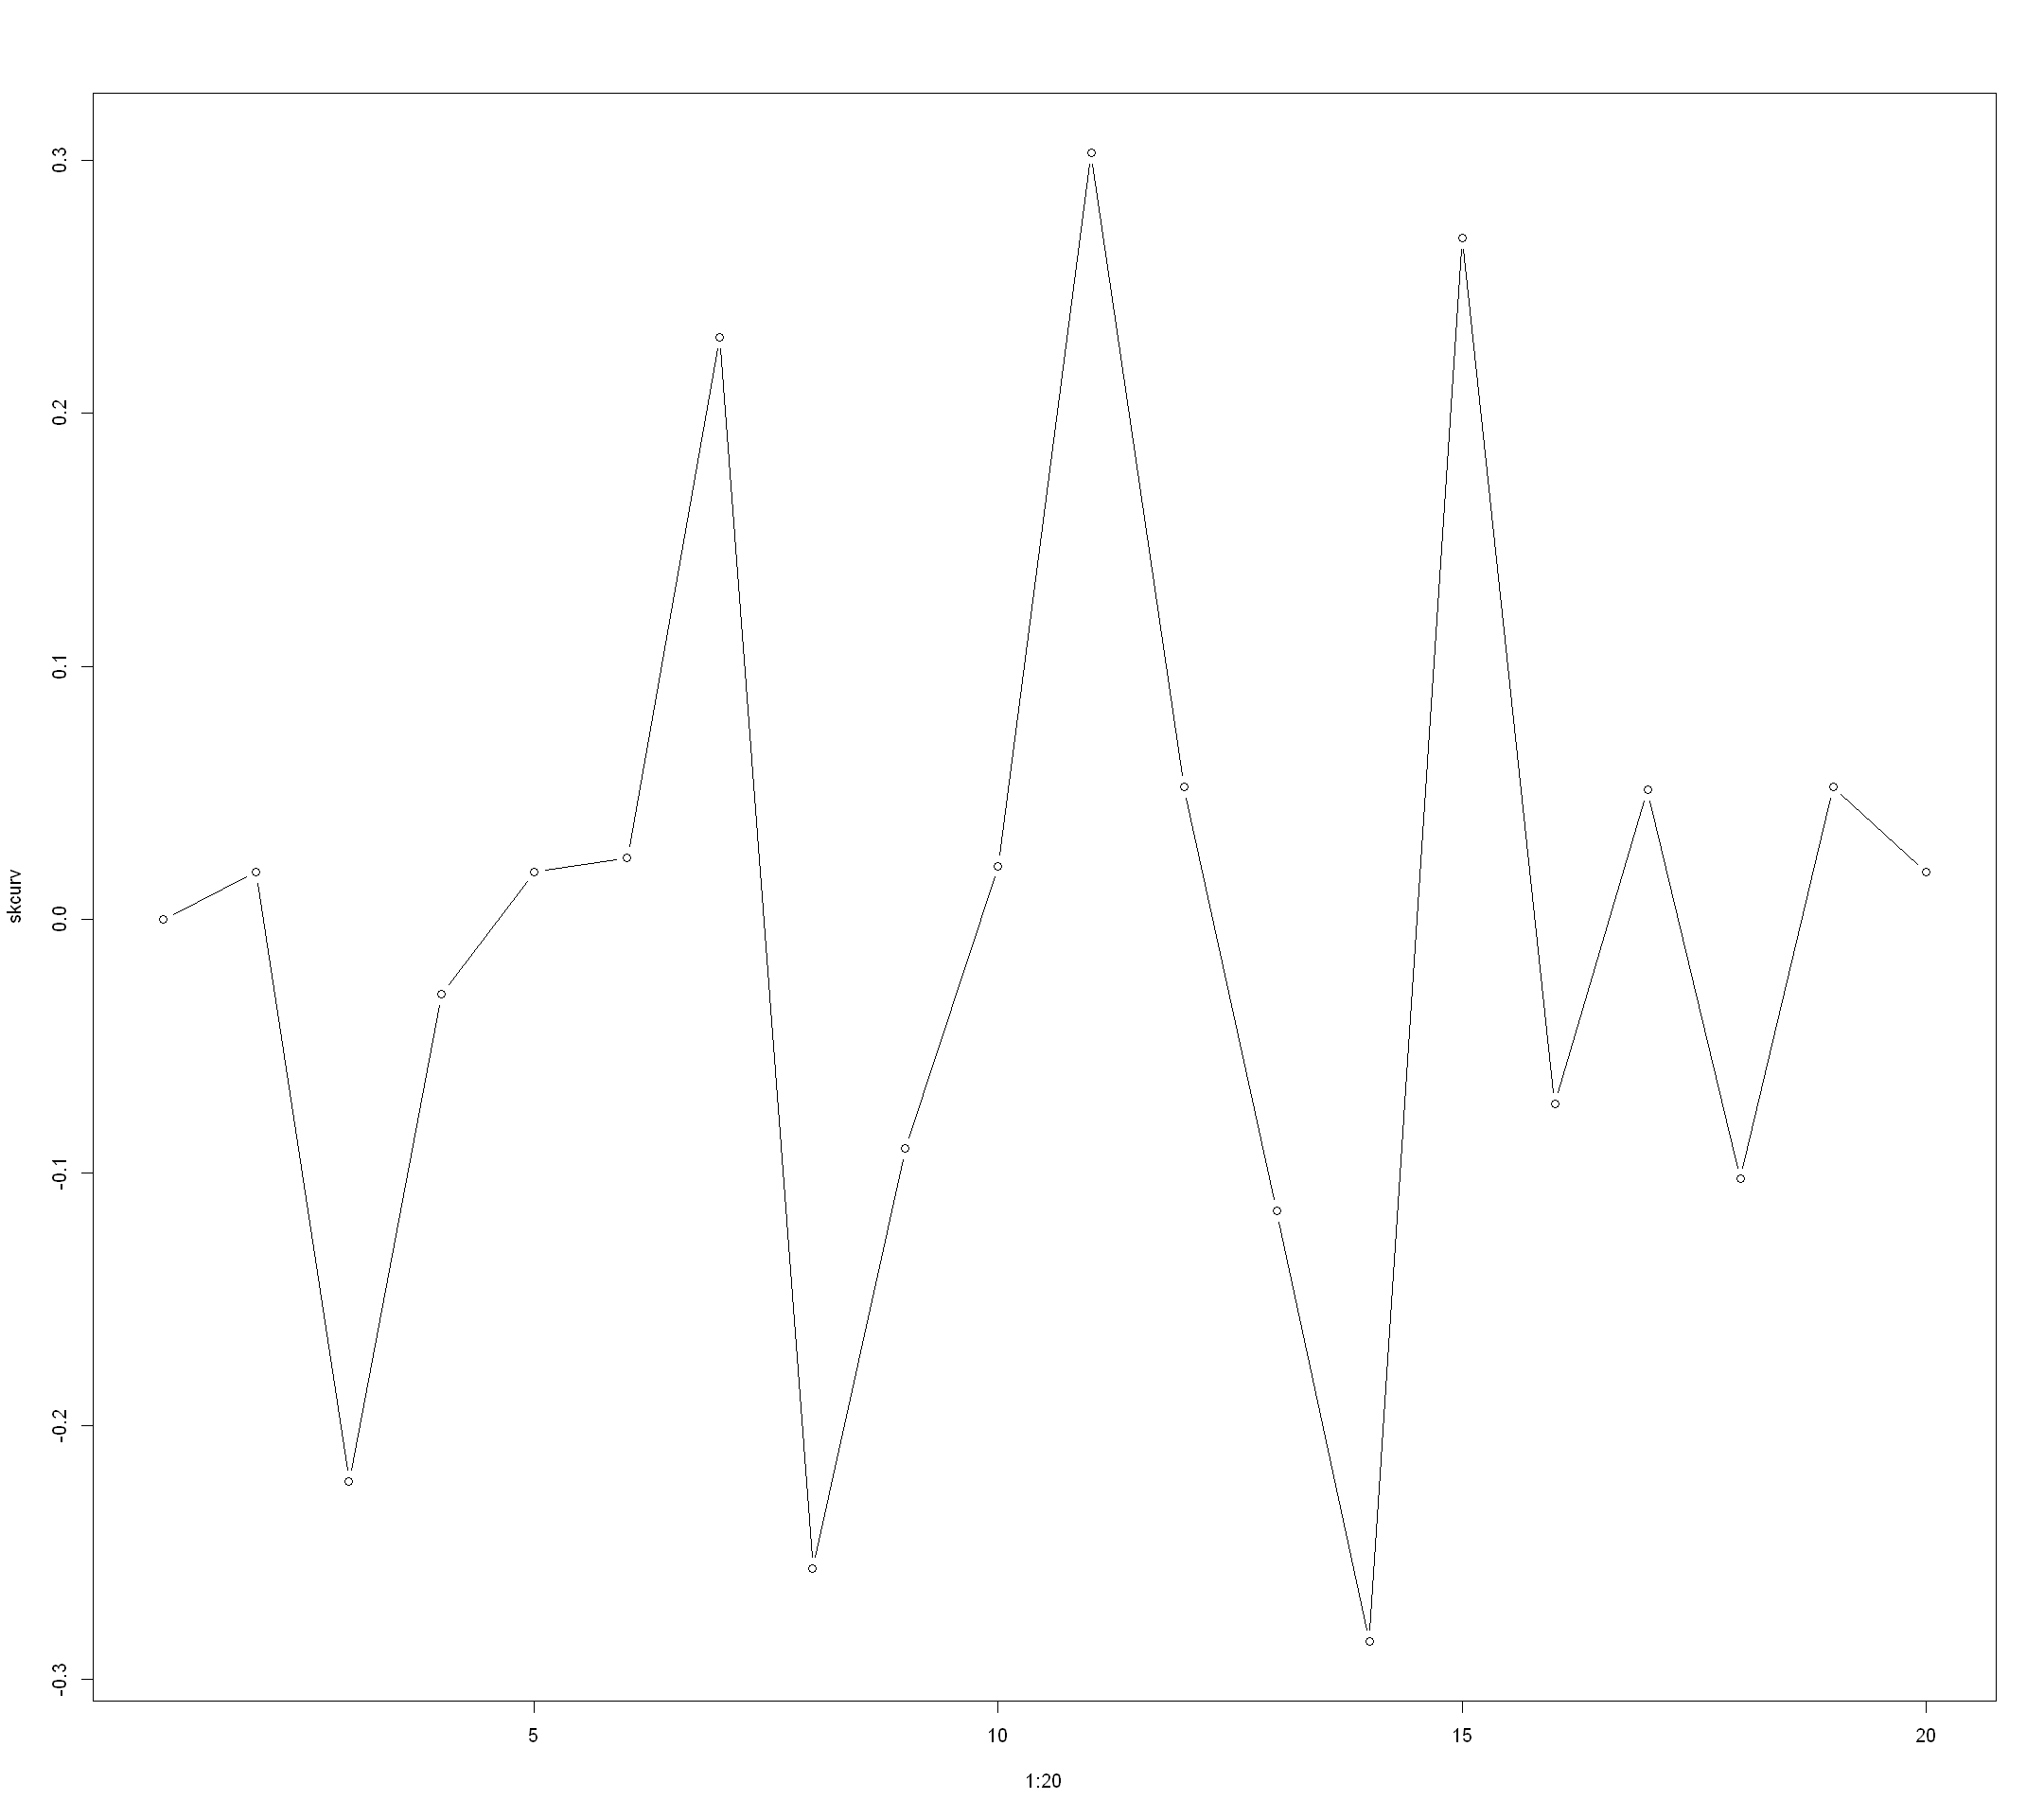

In [110]:
# scegliamo uno spazio LSA con piu' dimensioni e quindi con minore perdita d'informazione.
# Individuamo il punto di knee nella sequenza degli autovalori visualizzati in precedenza
# tra i minimi locali della funzione di curvatura sottodefinita della sequenza di autovalori 
fordiff <- function(x) x[2:length(x)] - x[1:(length(x)-1)]
skd <- fordiff(lsar$sk)
skdd <- fordiff(skd)
skcurv <- skdd[1:20] / (1+(skd[1:20])^2)^1.5
plot( 1:20, skcurv, type="b" )


In [111]:
# proviamo a selezioanre le prime 4 dimensioni dello spazio LSA
# ed estraiamo da questo spazio i primi 10 doc semanticamente piu' simili alla query  
texts[top(cosines(dls[,1:4], awls[1:4]), 10)]

[1] "Trash the book!: The book is all nonsense. Want to read a book about Michael? Read Letters to Michael Jackson."                                                                                                                                       
 [2] "Factual errors abound: This book has more than its fair share of factual errors. Double check anything you read in it."                                                                                                                               
 [3] "Well written, but not convincing.: Lewis is skilled with the language, so the book is a pleasure to read. But it is simplistic, relies on assumptions, and over-uses analogies."                                                                      
 [4] "Avoiding Capital Gains tax: A worthwhile read if you are involved in selling real estate.Using the book I was able to discuss intelligently the sale of my commercial building with my lawyer,accountant,and buyer."                                  
 [5] "21st century reading: It was interesting to read this book again in 2006. It is fascinating to read this book and then analysis and compare the different governments in today's world."                                                              
 [6] "Tour of Duty: This book is nothing but lies and propaganda. Nothing in this book is factual. Nothing but Walter Mitty."                                                                                                                               
 [7] "Nursing as a Ministry: Again, Sr Mary Elizabeth O'Brien has writeen an excellent book. I give this book to nurses when they graduate. It truly puts nurses in an angelic and spiritual perspective which they deserve."                               
 [8] "This book was mediacator: I thought this was a very UNREALISTIC BOOK. I thought was written very poor."                                                                                                                                               
 [9] "BOOK REVIEW: DEPRESSING BUT HOPEFUL BOOK ABOUT RECOVERY FROM DRUG AND ALCOLHOL ADDICTION AND RETURN TO NORMAL, SOBER LIFE."                                                                                                                           
[10] "worst book i have ever read: this book was excruciatingly painful to read. when i read this book i finally understood the definition of the word infinity. i would recomend this book to friends who have insomnia or those who i absolutely despise."

In [112]:
#Iteriamo il metodo sopra esposto cercando nello spazio 
# LSA a 4 dimensioni quali altri termini sono semanticamente piu' correlati alla coppia terrible book  
# percio' dobbiamo applicare il calolco della similarita' semantica tra una query e un termine
tksrs <- lsar$tk %*% diag( sqrt( lsar$sk ) )
awdksrs <- awls %*% diag( lsar$sk^-0.5 )

# elenco dei termini in ordine crescente di similarita' semantica con la coppia terrible book
sort( cosines( tksrs[,1:4], awdksrs[1:4] ) ) 
# coseno tra -1 e 1 perché lo spazio vettoriale comprende anche i quadranti negativi


musical          radio            pop           disc        singing 
 -3.924185e-01  -3.919076e-01  -3.881938e-01  -3.726162e-01  -3.693394e-01 
         music            dvd        release          songs        minutes 
 -3.691873e-01  -3.655280e-01  -3.536928e-01  -3.516847e-01  -3.511392e-01 
          band          album           rock         albums         lyrics 
 -3.493035e-01  -3.467169e-01  -3.451659e-01  -3.413109e-01  -3.406043e-01 
          song          sound    performance         player       released 
 -3.394938e-01  -3.393214e-01  -3.342037e-01  -3.251026e-01  -3.238262e-01 
        tracks        machine          video        garbage       features 
 -3.196136e-01  -3.100908e-01  -3.029258e-01  -3.004951e-01  -2.994981e-01 
        sounds       listened          extra        effects    replacement 
 -2.977263e-01  -2.905255e-01  -2.900288e-01  -2.884733e-01  -2.879453e-01 
        record         talent          plays            cds          voice 
 -2.870965e-01  -2.865431e-01  -2.864855e-01  -2.810824e-01  -2.768201e-01 
          cool          track           hour     production         played 
 -2.753117e-01  -2.722278e-01  -2.714408e-01  -2.693924e-01  -2.691484e-01 
           hot          broke           clay            toy        plastic 
 -2.683270e-01  -2.648820e-01  -2.647798e-01  -2.645893e-01  -2.621471e-01 
          beat         listen           play          cheap        replace 
 -2.606022e-01  -2.589762e-01  -2.571079e-01  -2.569069e-01  -2.530639e-01 
        bottom         comedy           crap        playing          watch 
 -2.515262e-01  -2.496781e-01  -2.493369e-01  -2.473724e-01  -2.440428e-01 
        actors        package          films        company            box 
 -2.435540e-01  -2.424031e-01  -2.407353e-01  -2.406919e-01  -2.404304e-01 
          junk           hear         screen         acting            hit 
 -2.386157e-01  -2.357264e-01  -2.345059e-01  -2.338762e-01  -2.313135e-01 
         brand           film      listening        special          clean 
 -2.306066e-01  -2.284088e-01  -2.249608e-01  -2.244930e-01  -2.186491e-01 
           cut          scene           fans           cast       customer 
 -2.174875e-01  -2.153612e-01  -2.148608e-01  -2.139827e-01  -2.113745e-01 
       quality           role         design          heavy        watched 
 -2.106942e-01  -2.092034e-01  -2.091342e-01  -2.073027e-01  -2.064356e-01 
         store      expensive       computer        stopped      christmas 
 -2.061164e-01  -2.050930e-01  -2.034289e-01  -2.021765e-01  -2.020546e-01 
         apart         movies         decent            low            air 
 -2.012804e-01  -2.008792e-01  -2.000636e-01  -1.994165e-01  -1.994072e-01 
         looks           hell         theyre       returned         single 
 -1.986047e-01  -1.980999e-01  -1.976717e-01  -1.976446e-01  -1.970700e-01 
          cute           guys        product          model          heard 
 -1.967051e-01  -1.961942e-01  -1.961014e-01  -1.960741e-01  -1.945394e-01 
          item          month         script       watching       shipping 
 -1.939562e-01  -1.919616e-01  -1.905416e-01  -1.893088e-01  -1.891479e-01 
           fit         beware           stay         return         worked 
 -1.888718e-01  -1.884330e-01  -1.856838e-01  -1.856664e-01  -1.853409e-01 
         hours           game           send            top        service 
 -1.842719e-01  -1.807160e-01  -1.803779e-01  -1.788912e-01  -1.785277e-01 
         movie            saw           tape          break         months 
 -1.733371e-01  -1.731323e-01  -1.725878e-01  -1.705749e-01  -1.689351e-01 
     perfectly       products           room        running        regular 
 -1.678235e-01  -1.674852e-01  -1.663519e-01  -1.653721e-01  -1.653545e-01 
       support           unit         scenes         buying        awesome 
 -1.653353e-01  -1.651611e-01  -1.642706e-01  -1.641210e-01  -1.638856e-01 
         local        battery        pleased          c

In [113]:
# scegliamo i termini con elevata similarità coseno e norma massima, percio' estraiamo la norma 
# di quelli con similarita' cosine a terrible book maggiore di 0.8  
tnorms4 <- apply( tls[,1:4], 1, norm, "2" )
tnorms4[cosines(tksrs[,1:4],awdksrs[1:4])>0.8] # instrument ha norma piu' alta, i.e. piu' rilevante


reading     read     book    books 
12.04505 19.59339 31.18709 13.08711

In [114]:
# definizione funzione per velocizzare il calcolo della similarita' tra query e termini in LSA
makequery <- function(Q, TDM, LSA) {
  V <- query( Q, rownames(TDM) )
  W <- lw_logtf(V) * (1-entropy(TDM))
  LS <- t(W) %*% LSA$tk
  DK <- LS %*% diag(LSA$sk^-1)
  DKSRS <- DK %*% diag(sqrt(LSA$sk))
  list( query=Q, bin=V, v=W, dk=DK, ls=LS, dksrs=DKSRS )
}


In [115]:
awi <- makequery( "terrible book", tdm, lsar )
texts[top(cosines(dls[,1:4],awi$ls[1:4]),10)] # prime 10 recensioni più rilevanti per la nuova query

[1] "Trash the book!: The book is all nonsense. Want to read a book about Michael? Read Letters to Michael Jackson."                                                                                                                                       
 [2] "Factual errors abound: This book has more than its fair share of factual errors. Double check anything you read in it."                                                                                                                               
 [3] "Well written, but not convincing.: Lewis is skilled with the language, so the book is a pleasure to read. But it is simplistic, relies on assumptions, and over-uses analogies."                                                                      
 [4] "Avoiding Capital Gains tax: A worthwhile read if you are involved in selling real estate.Using the book I was able to discuss intelligently the sale of my commercial building with my lawyer,accountant,and buyer."                                  
 [5] "21st century reading: It was interesting to read this book again in 2006. It is fascinating to read this book and then analysis and compare the different governments in today's world."                                                              
 [6] "Tour of Duty: This book is nothing but lies and propaganda. Nothing in this book is factual. Nothing but Walter Mitty."                                                                                                                               
 [7] "Nursing as a Ministry: Again, Sr Mary Elizabeth O'Brien has writeen an excellent book. I give this book to nurses when they graduate. It truly puts nurses in an angelic and spiritual perspective which they deserve."                               
 [8] "This book was mediacator: I thought this was a very UNREALISTIC BOOK. I thought was written very poor."                                                                                                                                               
 [9] "BOOK REVIEW: DEPRESSING BUT HOPEFUL BOOK ABOUT RECOVERY FROM DRUG AND ALCOLHOL ADDICTION AND RETURN TO NORMAL, SOBER LIFE."                                                                                                                           
[10] "worst book i have ever read: this book was excruciatingly painful to read. when i read this book i finally understood the definition of the word infinity. i would recomend this book to friends who have insomnia or those who i absolutely despise."

In [116]:
###############################################################################################

In [117]:
#Creation of a two dimension matrix to find similar documents from word embedding
someData <- rep(NaN, 10*200*50);  
ar <- array(someData ,c(10, 200, 50)); 
c = 1
counter = 1
for (d in 1:10){
    for(w in train.indices[d,]){
        if(w != 0){
            for(s in wordvecs[w,]){
            ar[d,c,counter] <- s
            counter = counter + 1
            }
        }else{
            for(a in 1:50)
            ar[d,c,a] <- 0
        }
        counter = 1
        c = c + 1
    }
c = 1
}

SomeData <- rep(NaN, 10*50);  
arr <- array(SomeData ,c(10,50)); 
for (f in 1:10){
    d <- ar[f,,]
    dd <- matrix(d, nrow = 50, byrow = TRUE)
    for(e in 1:50){
        res = mean(dd[e,])
        arr[f,e] <- res
    }
}


#most similar documents to document 1: six and two
sim2(arr, arr[1,,drop=FALSE], method="cosine", norm="l2")

#let's check it
texts[1]
texts[6]
texts[2]
texts[3] #three is the less similar

[,1]     
 [1,] 1.0000000
 [2,] 0.9748742
 [3,] 0.9622151
 [4,] 0.9603219
 [5,] 0.9580675
 [6,] 0.9796670
 [7,] 0.9620927
 [8,] 0.9476921
 [9,] 0.9613999
[10,] 0.9482086

[1] "The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny."

[1] "Buyer beware: This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family and friends--or perhaps, by herself! I can't imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad enough to be entered into some kind of a worst book contest. I can't believe Amazon even sells this kind of thing. Maybe I can offer them my 8th grade term paper on To Kill a Mockingbird--a book I am quite sure Ms. Haddon never heard of. Anyway, unless you are in a mood to send a book to someone as a joke---stay far, far away from this one!"

[1] "Amazing!: This soundtrack is my favorite music of all time, hands down. The intense sadness of Prisoners of Fate (which means all the more if you've played the game) and the hope in A Distant Promise and Girl who Stole the Star have been an important inspiration to me personally throughout my teen years. The higher energy tracks like Chrono Cross ~ Time's Scar~, Time of the Dreamwatch, and Chronomantique (indefinably remeniscent of Chrono Trigger) are all absolutely superb as well.This soundtrack is amazing music, probably the best of this composer's work (I haven't heard the Xenogears soundtrack, so I can't say for sure), and even if you've never played the game, it would be worth twice the price to buy it.I wish I could give it 6 stars."

[1] "Excellent Soundtrack: I truly like this soundtrack and I enjoy video game music. I have played this game and most of the music on here I enjoy and it's truly relaxing and peaceful.On disk one. my favorites are Scars Of Time, Between Life and Death, Forest Of Illusion, Fortress of Ancient Dragons, Lost Fragment, and Drowned Valley.Disk Two: The Draggons, Galdorb - Home, Chronomantique, Prisoners of Fate, Gale, and my girlfriend likes ZelbessDisk Three: The best of the three. Garden Of God, Chronopolis, Fates, Jellyfish sea, Burning Orphange, Dragon's Prayer, Tower Of Stars, Dragon God, and Radical Dreamers - Unstealable Jewel.Overall, this is a excellent soundtrack and should be brought by those that like video game music.Xander Cross"